### COMS4060A/7056A: Assignment #1
**University of the Witwatersrand**  
**Lecturer:** Muhammad Nasir (<muhammad.nasir@wits.ac.za>)  
**Date:** September 2025

---

**Group Name:** *Visionaries*

**Members**

- Karabo Mohapeloa
- Taruna Naidoo
- Humani Nenzhelele - 1602841
- Daniel Ngobe - 2556833


## 1. Data Cleaning

This dataset relies heavily on user input from around the world. Expect issues such as:
- **`date fueled`** sometimes containing free-text descriptions instead of dates.
- **Numeric fields** (e.g., `gallons`, `miles`, `odometer`) written with thousands separators (e.g., `1,523.50`) that must be cleaned before conversion.
- **Cost fields** (`cost per gallon`, `total spent`) that include currency symbols (e.g., `R500`, `$500`) across many currencies.

In [56]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import math
import scipy.stats as stats
import warnings 
import matplotlib
import matplotlib.cm as cm
sns.set(rc={'figure.figsize':(12,6)})
warnings.simplefilter(action='ignore', category= FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

%matplotlib inline

import missingno

In [57]:
df = pd.read_csv(
    "logbook_assignment1.csv",
    low_memory=False  # avoids the warning, but doesn't fix dirty values
)

df.shape

(1174870, 9)

In [58]:
df.sample(5)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
1088306,Apr 1 2021,Apr 1 2021,"98,409",8.990,€5.62,€50.53,17.5,NaN,https://www.somewebsite.com/fiat/ducato/2003/9...
1159026,May 31 2021,May 31 2021,NaN,15.259,$2.879,$43.93,30.2,461.1,https://www.somewebsite.com/subaru/legacy/2012...
296032,Apr 8 2015,Apr 8 2015,"113,005",20.507,NaN,$0.00,14.7,NaN,https://www.somewebsite.com/toyota/land_cruise...
821774,May 18 2014,May 19 2014,"18,841",11.272,£5.30,£59.70,41.0,NaN,https://www.somewebsite.com/alfa_romeo/mito/20...
211350,Jan 29 2016,Mar 7 2017,"171,372",2.690,$3.516,$9.46,0.0,NaN,https://www.somewebsite.com/volvo/v60_cross_co...


### 1.1 Date Fields

#### 1. Identify the **percentage of `date_fueled` entries that are not valid dates**. 

In [59]:
valid_dates = pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce').notna()
perc_invalid_dates = sum(valid_dates == False)/len(df)*100
print('Percentage of date_fueled entries not proper dates:', perc_invalid_dates, '%')
print('Number of invalid date_fueled entries:', sum(valid_dates == False))

Percentage of date_fueled entries not proper dates: 11.678738924306518 %
Number of invalid date_fueled entries: 137210


#### 2. Where `date_fueled` is invalid but **`date_captured` is valid**, **fill** `date_fueled` with `date_captured` as a proxy. 

In [60]:
valid_ = pd.to_datetime(df['date_captured'], format='%b %d %Y', errors='coerce').notna()
val_cap = sum(valid_ == True)/len(df)*100
print('Valid dates_captured:', val_cap, "%")
df['date_fueled_proxy'] = pd.to_datetime(np.where((pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce').notna() == False),df['date_captured'],df['date_fueled']), format='%b %d %Y', errors='coerce')

Valid dates_captured: 100.0 %


#### 3. **Convert** `date fueled` to a date type; set any invalid entries to **NaT**.

In [61]:
df['date_fueled'] = pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce')
df['date_captured'] = pd.to_datetime(df['date_captured'], format='%b %d %Y', errors='coerce')

print(df.dtypes)
df.sample(5)

date_fueled          datetime64[ns]
date_captured        datetime64[ns]
odometer                     object
gallons                      object
cost_per_gallon              object
total_spent                  object
mpg                          object
miles                        object
user_url                     object
date_fueled_proxy    datetime64[ns]
dtype: object


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_proxy
539431,2019-04-19,2019-04-19,NaN,7.957,TL13.70,TL109.03,23.7,188.9,https://www.somewebsite.com/renault/19/1996/82...,2019-04-19
562872,2019-07-18,2019-07-18,"124,533",12.896,$2.559,$33.00,18.9,NaN,https://www.somewebsite.com/mitsubishi/galant/...,2019-07-18
235804,2021-01-16,2021-11-06,"132,828",13.198,$1.499,$19.78,17.8,NaN,https://www.somewebsite.com/subaru/forester/20...,2021-01-16
12715,2019-09-30,2019-09-30,NaN,6.507,£4.77,£31.01,31.9,207.6,https://www.somewebsite.com/renault/megane/200...,2019-09-30
991087,2018-03-02,2018-03-02,NaN,19.633,CA$5.04,CA$98.85,18.3,359.8,https://www.somewebsite.com/audi/a6_quattro/20...,2018-03-02


#### 4. **Remove dates** that are in the **future** or **earlier than 2005**.

In [62]:
print("Before removing invalid dates, the shape of the dataframe is:", df.shape)

df = df.loc[(df['date_fueled_proxy'] >= '2005-01-01') & (df['date_fueled_proxy'] <= datetime.datetime.now())]

print("After removing invalid dates, the shape of the dataframe is:", df.shape)

Before removing invalid dates, the shape of the dataframe is: (1174870, 10)
After removing invalid dates, the shape of the dataframe is: (1174300, 10)



#### 5. **Plot the distribution** of fueling dates and **comment** on the results. 

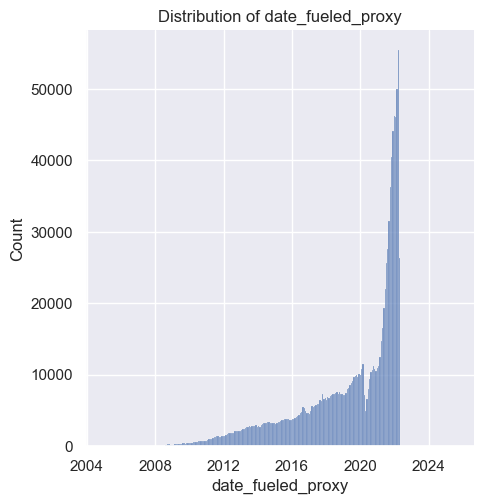

In [63]:
sns.displot(df, x="date_fueled_proxy")
plt.title("Distribution of date_fueled_proxy")
plt.show()

The distribution of fueling dates shows a gradual increase from 2005, suggesting that more users were logging fuel data over time, likely due to the platform gaining popularity. The sudden dip around 2020 could correspond to the global COVID-19 pandemic, when lockdowns and travel restrictions sharply reduced vehicle usage. The subsequent rapid increase may reflect a rebound as restrictions eased and more users returned where acustomed to digital spaces because of working from home.

### 1.2 Numeric Fields

#### 1. Identify what percentage of `gallons`, `miles`, and `odometer` entries are missing

In [64]:
percent_nulls = (df[['gallons', 'miles', 'odometer', 'mpg']].isna().sum()/len(df))*100
print(percent_nulls.astype(str) + ' %')

gallons      6.316188367538107 %
miles        87.55369156092992 %
odometer    12.691560929915694 %
mpg          6.316188367538107 %
dtype: object


#### 2. The `miles`, `gallons` and `mpg` columns are interdependent. If one is missing, the other two can be used to calculate it.

In [65]:
df['miles'] = df['miles'].replace(',', '', regex=True).astype(float)
df['odometer'] = df['odometer'].replace(',', '', regex=True).astype(float)
df['gallons'] = df['gallons'].replace(',', '', regex=True).astype(float)
df['mpg'] = df['mpg'].replace(',', '', regex=True).astype(float)

#The formula to calculate mpg: Miles driven ÷ gallons used to refill the tank
df['mpg'] = df['mpg'].fillna(df['miles']/df['gallons'])

#Formula for Miles: mpg*gallons
df['miles'] = df['miles'].fillna(df['mpg']*df['gallons'])

#Formula for gallons: miles/mpg
df['gallons'] = df['gallons'].fillna(df['miles']/df['mpg'])

print("After cleaning, the missing values are: \n")
percent_nulls = (df[['gallons', 'miles', 'mpg']].isna().sum()/len(df))*100
print(percent_nulls.astype(str) + ' %')


After cleaning, the missing values are: 

gallons    6.316188367538107 %
miles      6.316188367538107 %
mpg        6.316188367538107 %
dtype: object


#### 3. The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value).

In [66]:
df.dtypes

date_fueled          datetime64[ns]
date_captured        datetime64[ns]
odometer                    float64
gallons                     float64
cost_per_gallon              object
total_spent                  object
mpg                         float64
miles                       float64
user_url                     object
date_fueled_proxy    datetime64[ns]
dtype: object

#### 4. Plot the distributions and comment on the distributions

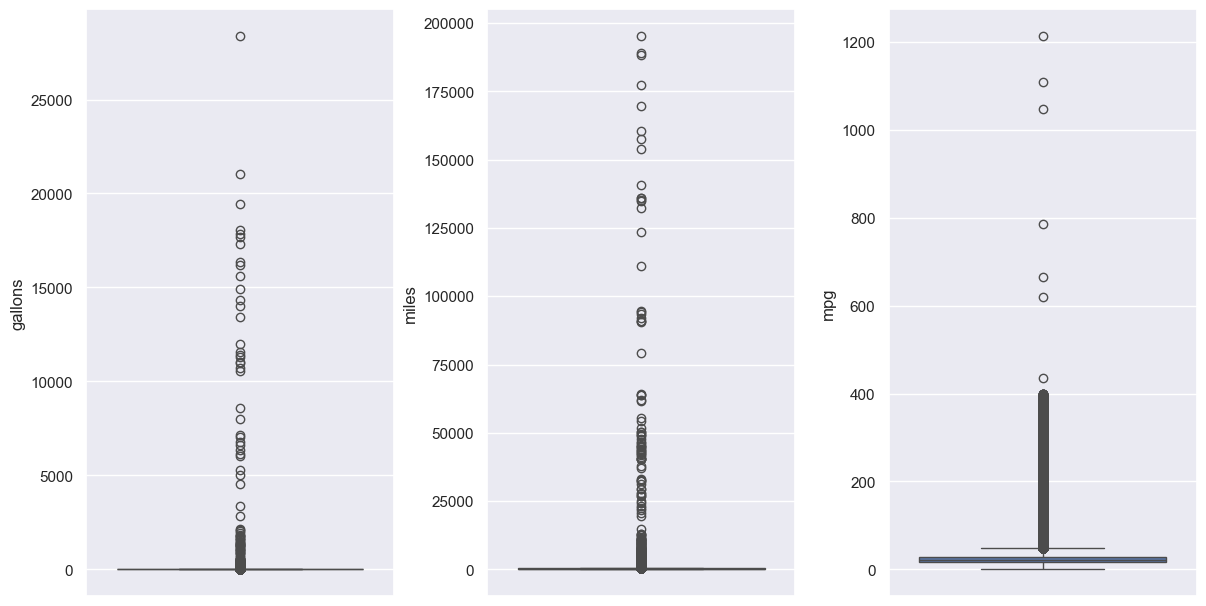

In [67]:
data_m_g_mpg = df[['gallons', 'miles', 'mpg']]
fig, axs = plt.subplots(ncols=3, nrows=1)
index = 0
axs = axs.flatten()
for k,v in data_m_g_mpg.items():
    sns.boxplot(y=k, data=data_m_g_mpg, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

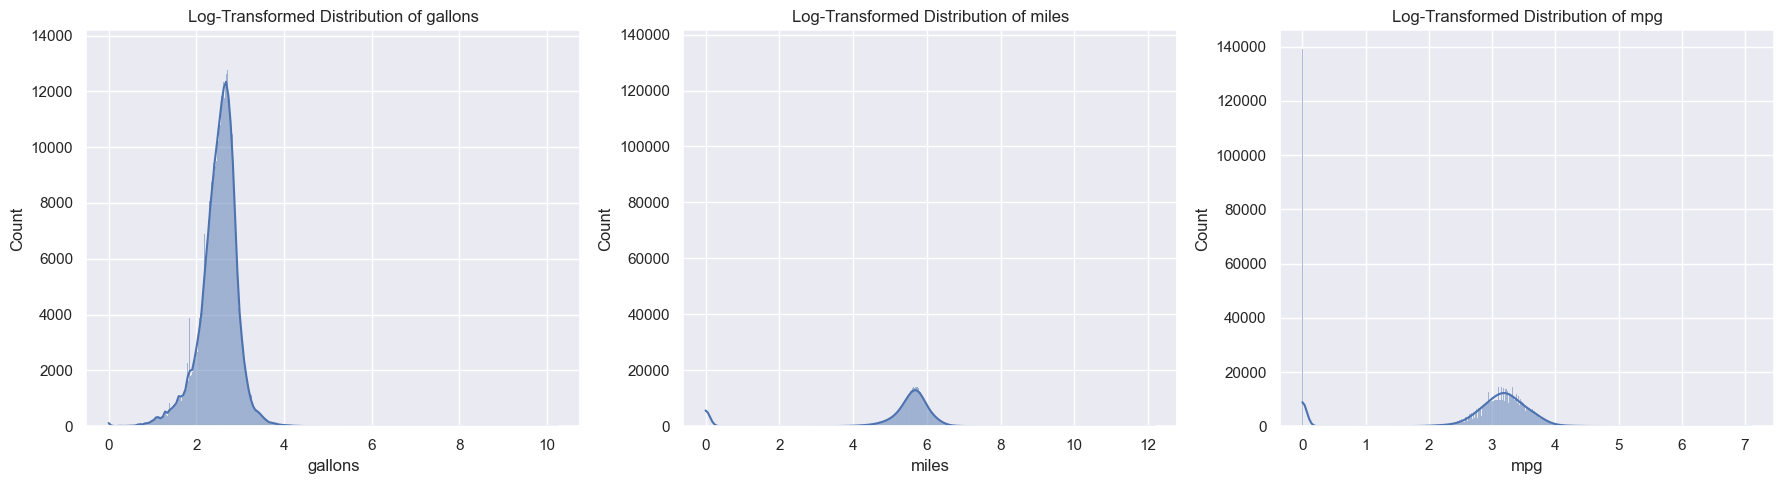

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, x in zip(axes, ['gallons', 'miles', 'mpg']):
    sns.histplot(np.log1p(df[x]), kde=True, ax=ax)
    ax.set_title(f'Log-Transformed Distribution of {x}')

plt.tight_layout()
plt.show()

 <center> REMEMBER TO COMMENT HERE ⁉️ </center>

5. Compute the statistical description of the columns: mean, standard deviation, max, min, most frequent, and quartiles. Do these results make
sense? [3]

In [69]:
# suppressing scientific notation when printing float values
pd.options.display.float_format = '{}'.format

df[['miles', 'gallons', 'mpg']].describe()

,miles,gallons,mpg
count,1100129.0,1100129.0,1100129.0
mean,269.45380130112017,12.79743047497157,22.163024699830657
std,725.7634370035393,74.48279111437775,15.744350144205049
min,0.0,0.0,0.0
25%,181.4,8.99,15.6
50%,267.0486,11.954,21.8
75%,342.7641,14.939,28.5
max,195321.2,28380.0,1214.3


These descriptions show that the mean for gallons is approximately 13 which makes sense, as I have mentioned that an average sized tank can hold between 12 to 18 gallons of fuel. There are clearly some extremes which do not make sense in this column. As we can see the maximum gallons is 28380, which seems highly unlikely for a car to be filled with that many gallons of fuel.

For mpg, the values make sense in relation to the values of miles and gallons. In reality, an average car (based in USA) gets an average of 25mpg. The average mpg here is 22 which is very close to 25, thus it makes sense in this aspect as well.

For miles, the average is 269 miles. This makes sense in relation to the average of 22mpg. If a car rides 269 miles based on 22mpg, on average they would consume 12-13 gallons of fuel. The maximum miles driven is 195321 miles. In relation to the extreme max value of gallons, this makes sense.

## 2 Feature engineering

#### 1. Create a new column with the currency. (Something to keep in mind is that the Swiss Franc has a period in the abbreviation).

In [70]:
df['currency'] = df['total_spent'].astype(str).str.extract(r'([^\d.,]+)')

#### 2. Create a new column containing the float value of the total spend and the cost per gallon. (Swiss Franc comment as above).

In [71]:
df["total_spent_float"] = df["total_spent"].str.extract(r"(\d*\.?\d+)", expand=True).astype(float)
df['cpg_float'] = df['cost_per_gallon'].str.extract(r"(\d*\.?\d+)", expand=True).astype(float)

#### 3. Car make, model, year, User ID: use the url (the last value in the URL is the user ID)


In [72]:
print(df['user_url'].head(10))

df['car_make'] = df['user_url'].str.split('/').str[3]
df['car_model'] = df['user_url'].str.split('/').str[4]
df['car_year'] = pd.to_numeric(df['user_url'].str.split('/').str[-2], errors='coerce')
df['user_id'] = df['user_url'].str.split('/').str[-1]


df.loc[(df['car_year'] < 1800) | (df['car_year'] > datetime.datetime.now().year), 'car_year'] = np.nan


0    https://www.somewebsite.com/suzuki/swift/2015/...
1       https://www.somewebsite.com/bmw/x3/2009/461150
2    https://www.somewebsite.com/mercedes-benz/e300...
3     https://www.somewebsite.com/bmw/320d/2010/247233
4    https://www.somewebsite.com/honda/passport/201...
5    https://www.somewebsite.com/volkswagen/passat/...
6    https://www.somewebsite.com/mazda/3_sport/2010...
7    https://www.somewebsite.com/subaru/forester/20...
8     https://www.somewebsite.com/kianival/2009/789684
9    https://www.somewebsite.com/lexus/rx350/2012/8...
Name: user_url, dtype: object


#### The data is given in imperial units, and in SA, we use proper measurement standards.

1. litres filled: use the gallons - consider whether to use UK or US gallons.

In [73]:
# Formula to convert to litres from gallons: gallons*3.785411784
# US Standard: 1 US liquid gallon = 3,78541 Liter
# UK Standard: 1 UK Gallon  = 4.54609 Litres

df['litres_filled'] = df['gallons']*3.785411784

2. km driven: use the miles driven to compute this

In [74]:
# Formula to convert from miles to km: miles*1.60934
df['km_driven'] = df['miles']*1.60934


3. litres per 100km: use the two new features to calculate this.

In [75]:
# Formula for litres per 100km: (litres_filled/km_driven)*100
df['litres_per_100km'] = (df['litres_filled']/df['km_driven'])*100

In [76]:
new_order = [
    'user_id', 'date_fueled_proxy', 'currency', 'total_spent_float', 'cpg_float', 
    'car_make', 'car_model', 'car_year', 'km_driven',
    'litres_filled', 'litres_per_100km',
    'cost_per_gallon', 'total_spent',  
    'date_fueled', 'date_captured', 'miles', 'odometer', 'gallons', 'mpg',
    'user_url',
]

df = df[new_order]
df.sample(5)


,user_id,date_fueled_proxy,currency,total_spent_float,cpg_float,car_make,car_model,car_year,km_driven,litres_filled,litres_per_100km,cost_per_gallon,total_spent,date_fueled,date_captured,miles,odometer,gallons,mpg,user_url
29910,194374,2013-05-13,£,40.17,5.07,ford,focus,1998.0,0.0,29.9993883882,inf,£5.07,£40.17,2013-05-13,2013-05-13,0.0,96936.0,7.925,0.0,https://www.somewebsite.com/ford/focus/1998/19...
380402,359085,2021-07-10,AU$,100.17,5.56,audi,q5,2015.0,797.2428959,68.190407876976,8.553278834801842,AU$5.56,AU$100.17,2021-07-10,2021-07-10,495.385,75594.0,18.014,27.5,https://www.somewebsite.com/audi/q5/2015/359085
654050,811992,2021-05-15,$,41.0,3.299,toyota,tacoma,2008.0,358.01570760799996,47.045097651552,13.14051217637155,$3.299,$41.00,2021-05-15,2021-05-15,222.4612,116329.0,12.428,17.9,https://www.somewebsite.com/toyota/tacoma/2008...
1057382,907008,2020-11-07,R,833.09,52.81,hyundai,ix35,2011.0,685.50159168,59.718656304384,8.711672887298173,R52.81,R833.09,2020-11-07,2020-11-11,425.952,247053.0,15.776,27.0,https://www.somewebsite.com/hyundai/ix35/2011/...
713772,645509,2018-05-27,$,37.37,3.599,mitsubishi,endeavor,2007.0,317.48576718,39.303930553272,12.379745681950038,$3.599,$37.37,2018-05-27,2018-05-27,197.277,140807.0,10.383,19.0,https://www.somewebsite.com/mitsubishi/endeavo...


## 3. Vehicle Exploration

#### 1. Plot the number of unique users per country (remember, we proxy this by currency).

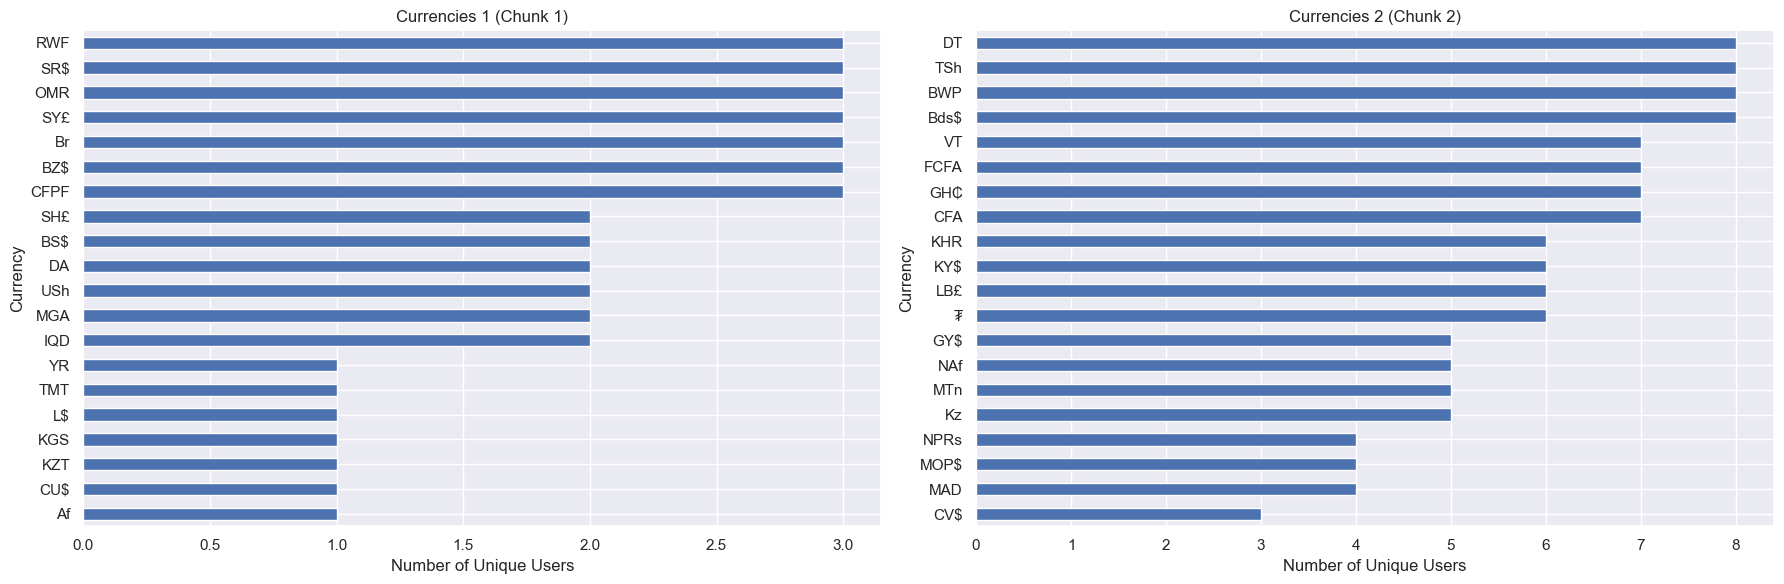

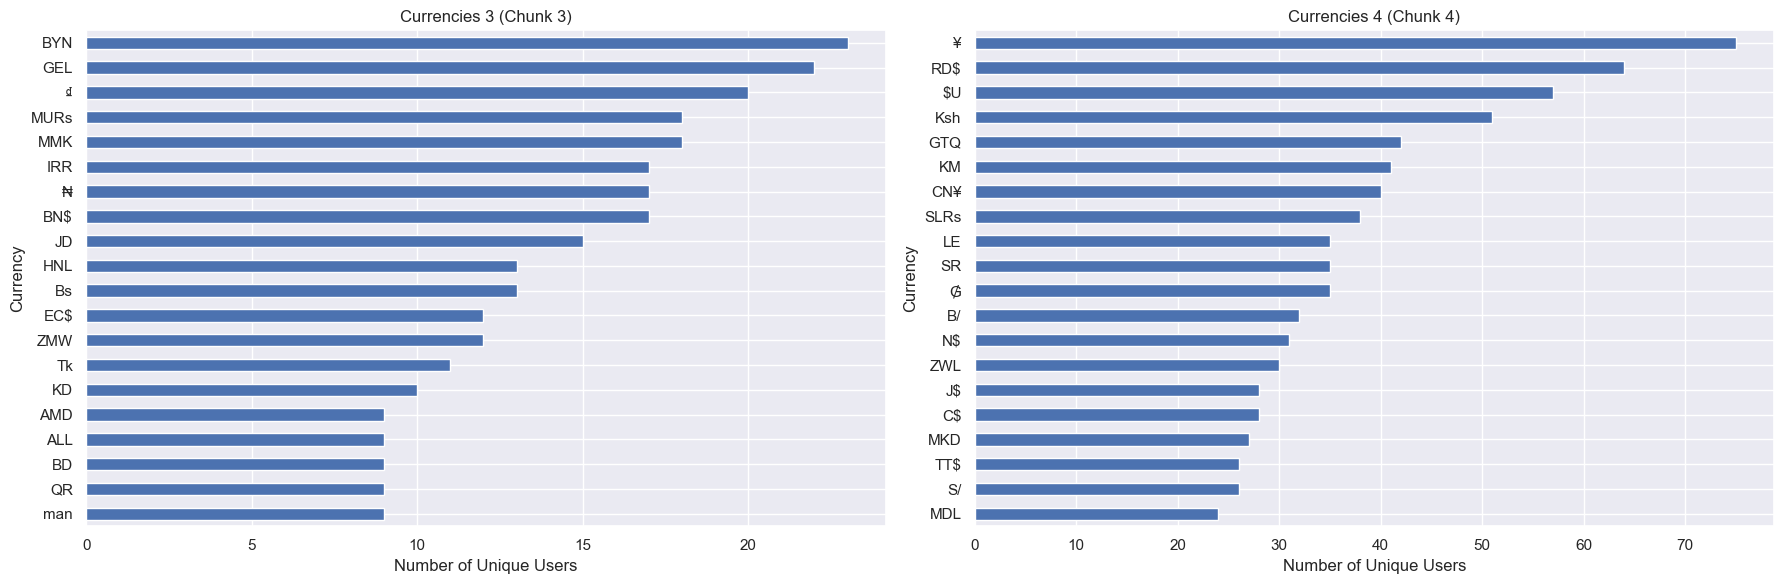

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\2951253697.py:22: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


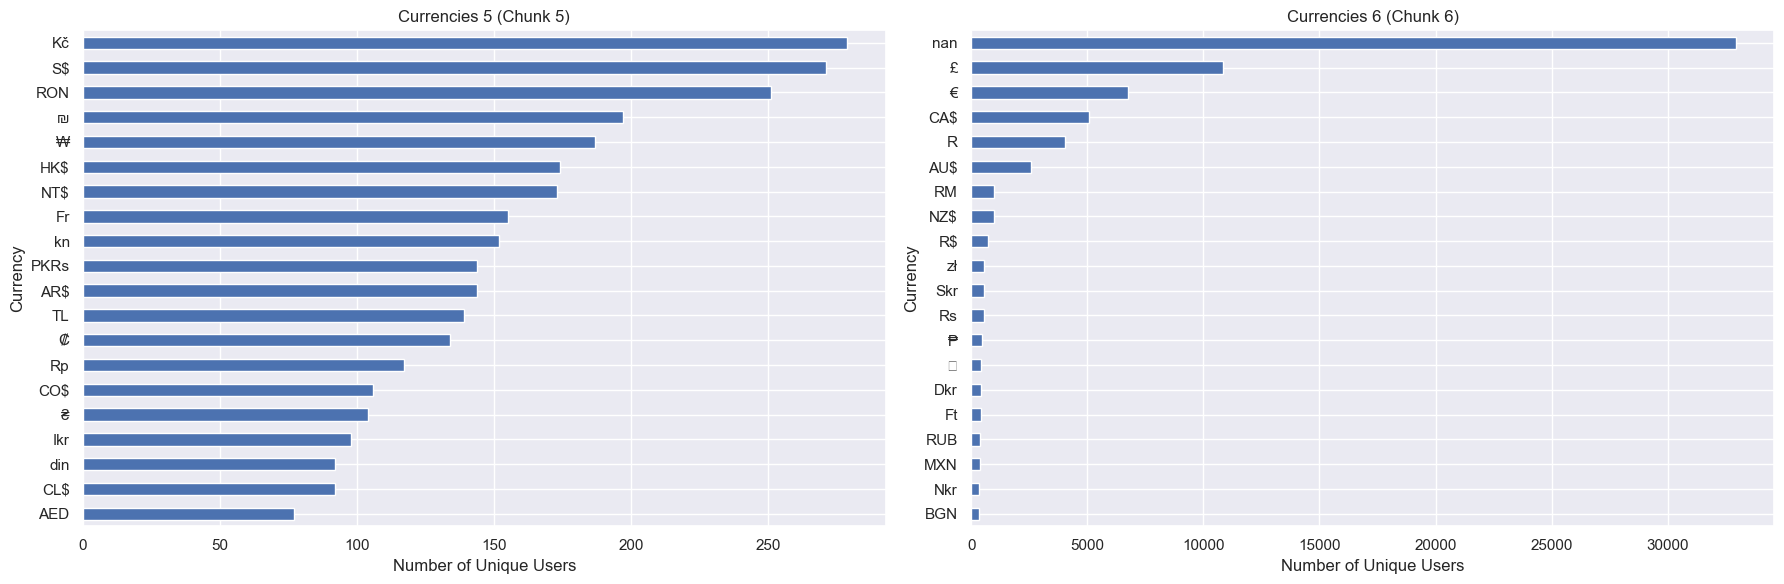

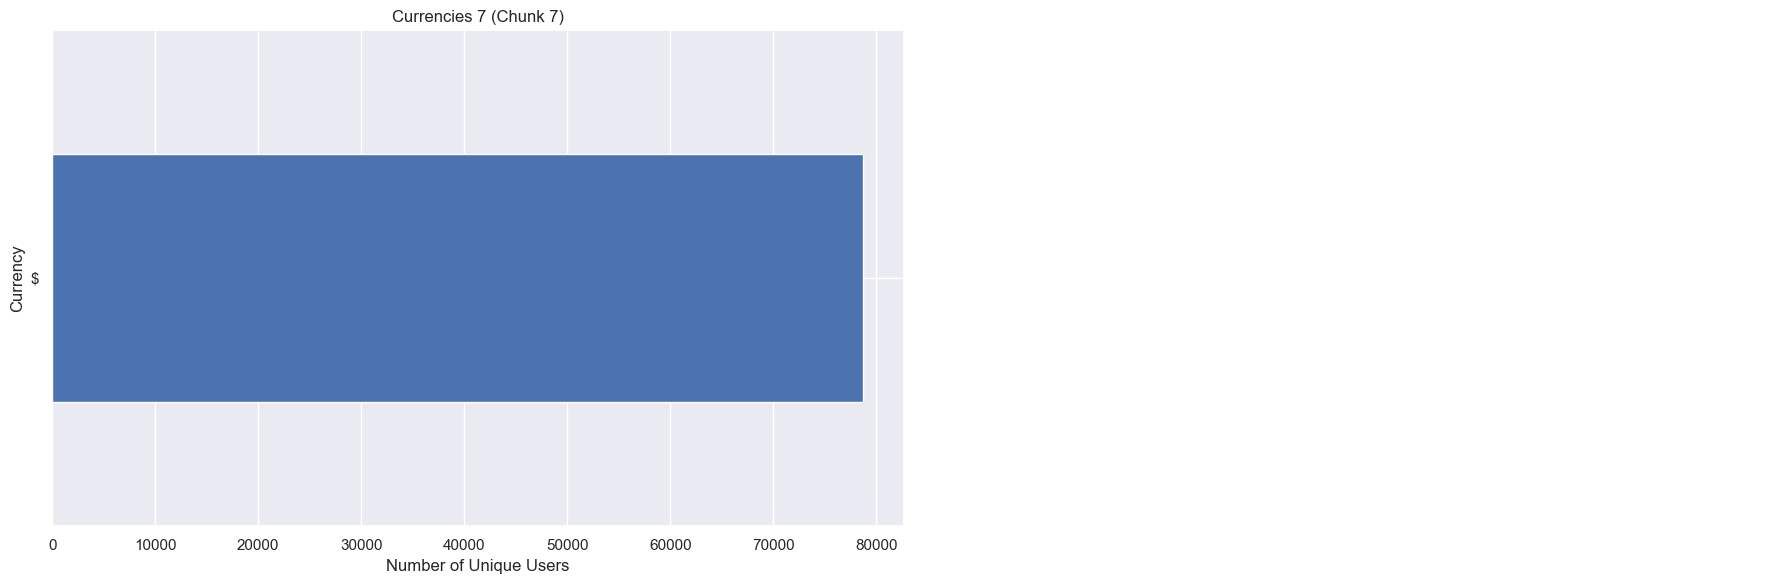

In [77]:
import matplotlib.pyplot as plt
import numpy as np

unique_users = df.groupby('currency')['user_id'].nunique().sort_values()

chunk_size = 20  # currencies per plot
chunks = [unique_users.iloc[i:i+chunk_size] for i in range(0, len(unique_users), chunk_size)]

# Plot 2 plots per row
for i in range(0, len(chunks), 2):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for j in range(2):
        if i+j < len(chunks):
            chunks[i+j].plot(kind='barh', ax=axes[j])
            axes[j].set_xlabel('Number of Unique Users')
            axes[j].set_ylabel('Currency')
            axes[j].set_title(f'Currencies {i+j+1} (Chunk {i+j+1})')
        else:
            axes[j].axis('off')  # turn off empty subplot

    plt.tight_layout()
    plt.show()


#### 2. Look at the popularity of the app: plot the number of unique users per day.

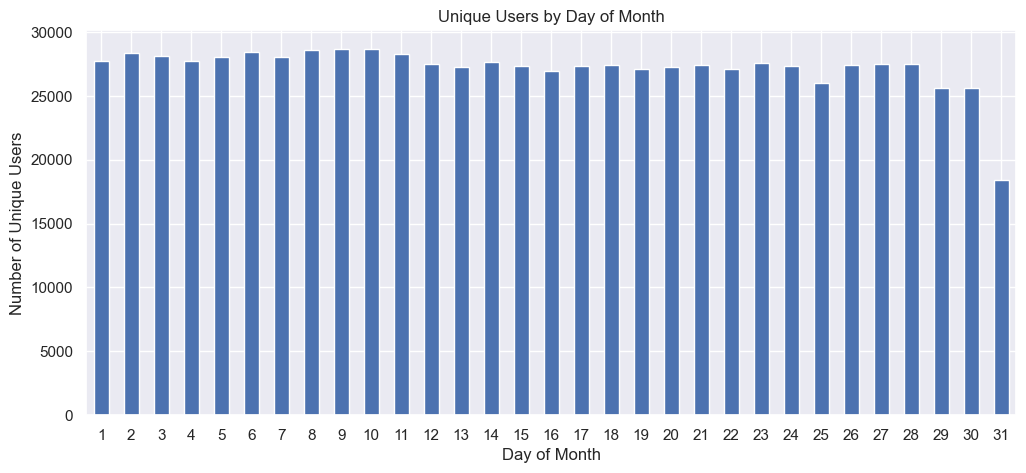

In [78]:
# Count unique users per day of month
users_per_day_of_month = df.groupby(df['date_captured'].dt.day)['user_id'].nunique()

# Plot
plt.figure(figsize=(12,5))
users_per_day_of_month.plot(kind='bar')
plt.xlabel('Day of Month')
plt.ylabel('Number of Unique Users')
plt.title('Unique Users by Day of Month')
plt.xticks(rotation=0)
plt.show()

The number of unique users per day is generally lower for the 31st and the highest from the 8th to the 10th

#### 3. Look at the distribution of age of the vehicles per country - look at the year of the vehicle. Remember to look at the date it was refuelled, not the current date.

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


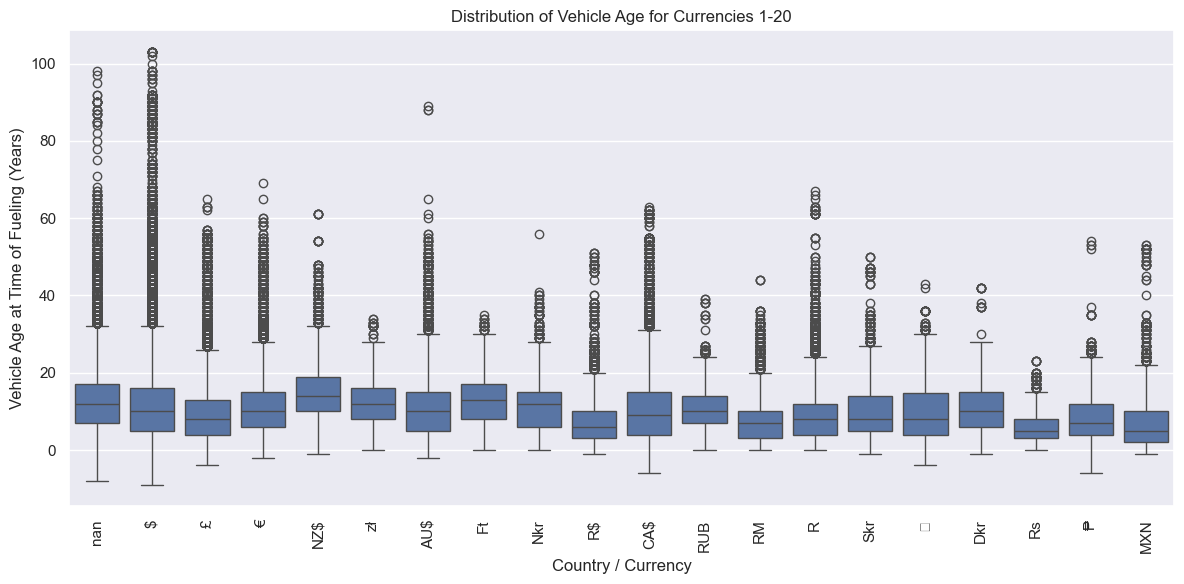

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


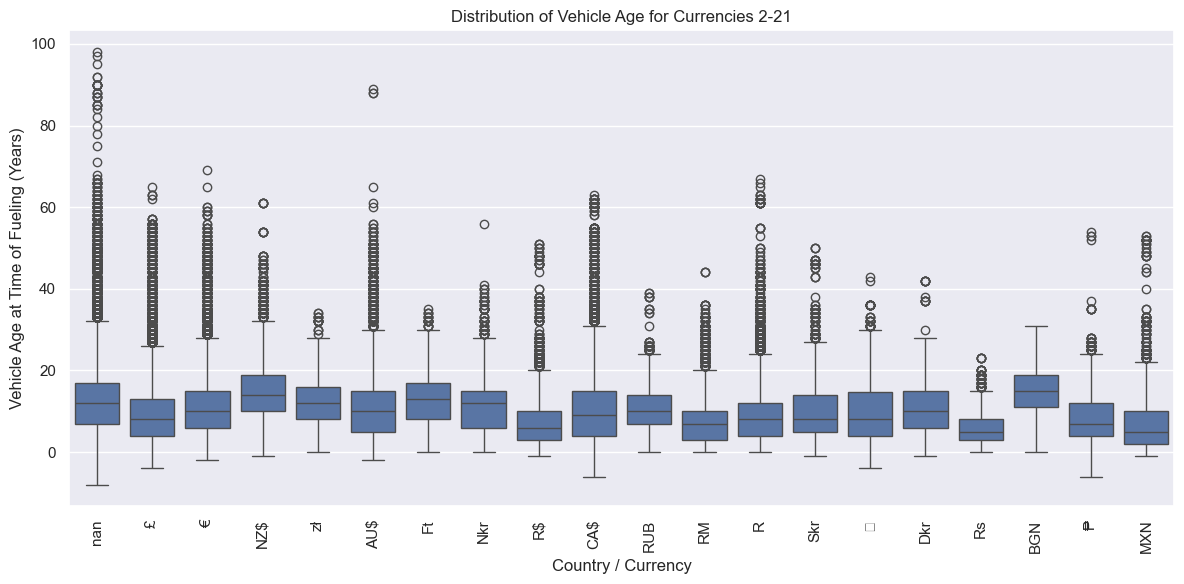

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


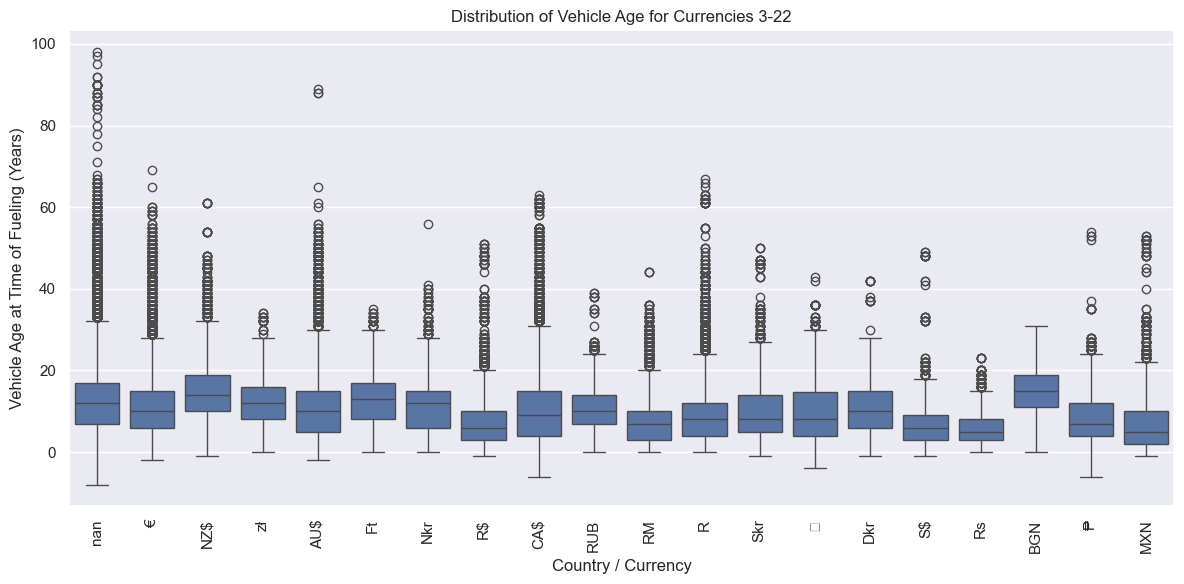

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


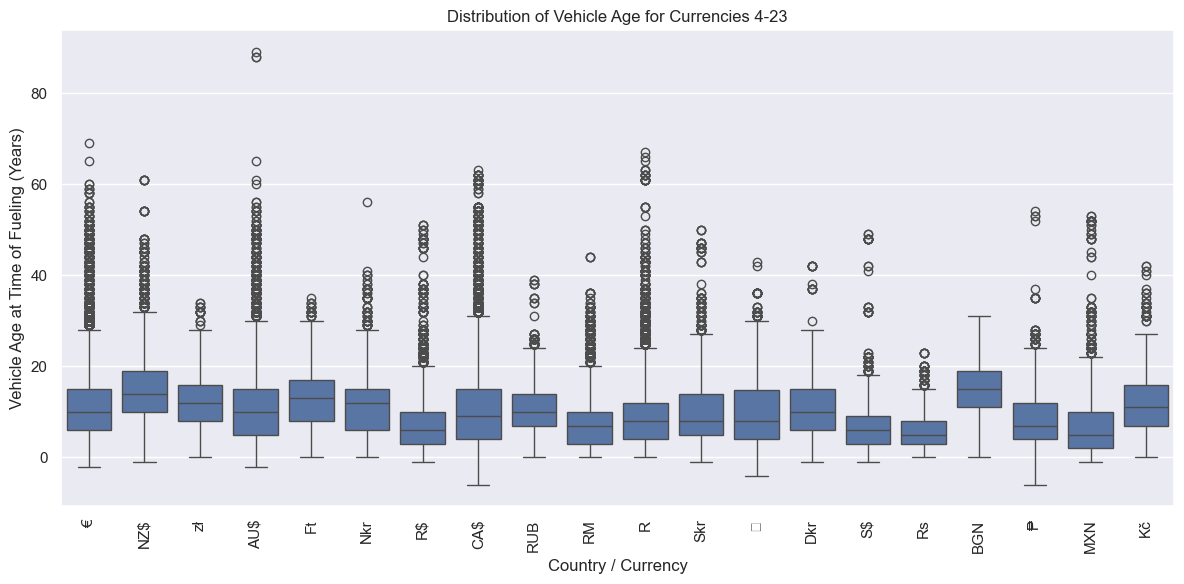

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


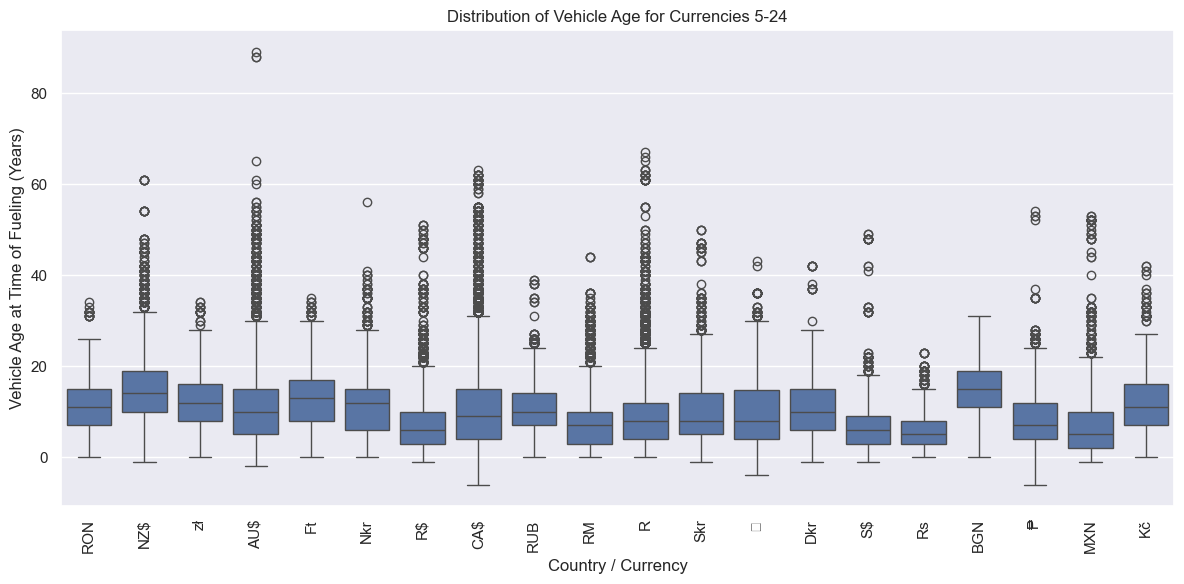

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


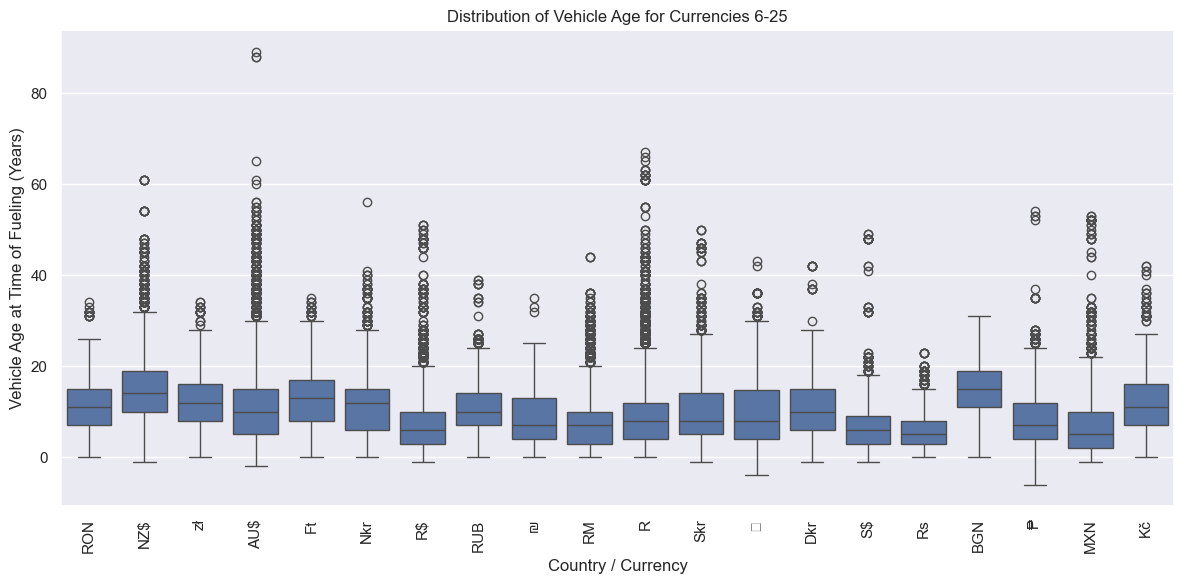

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


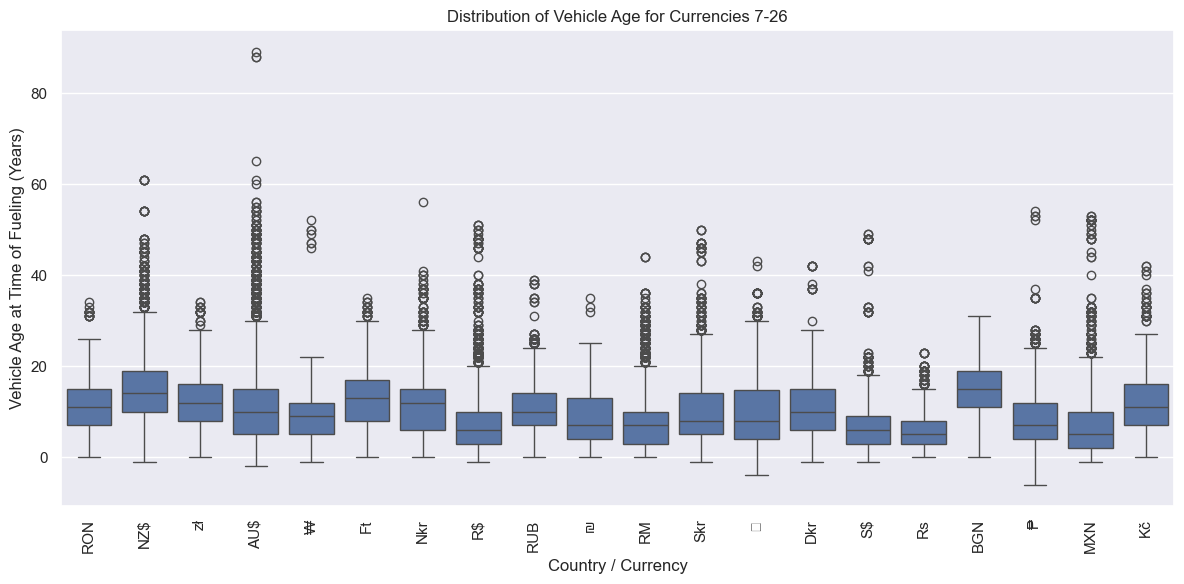

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


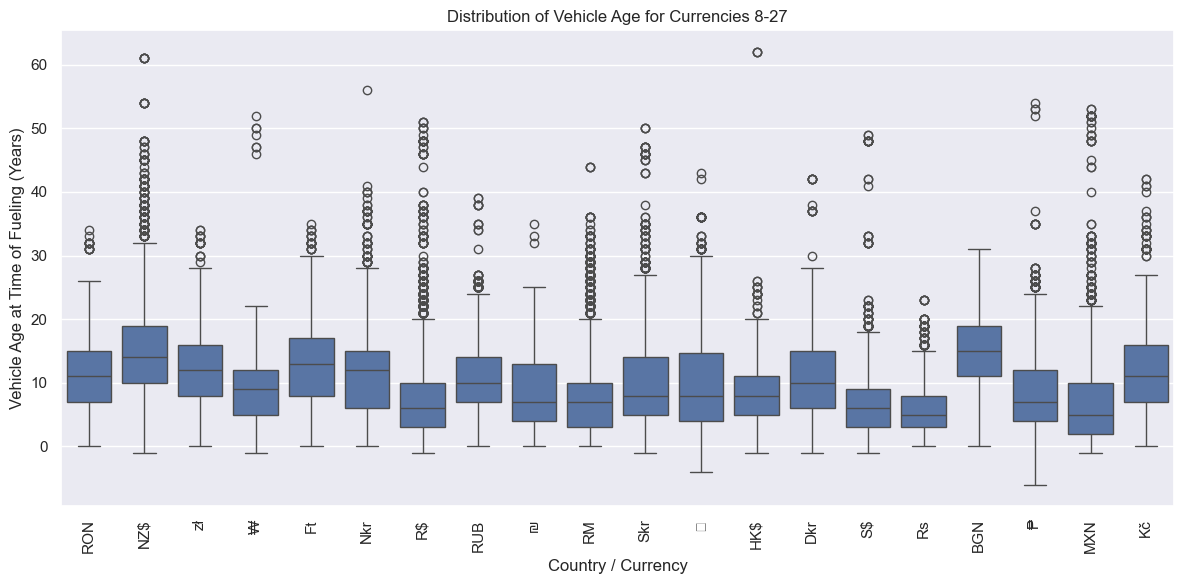

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


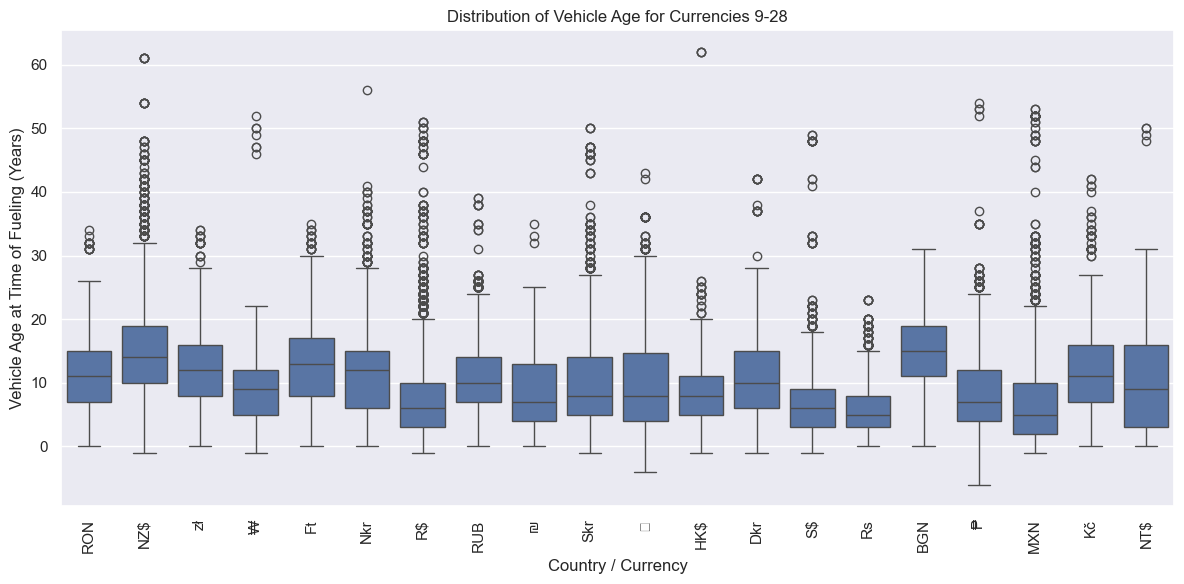

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


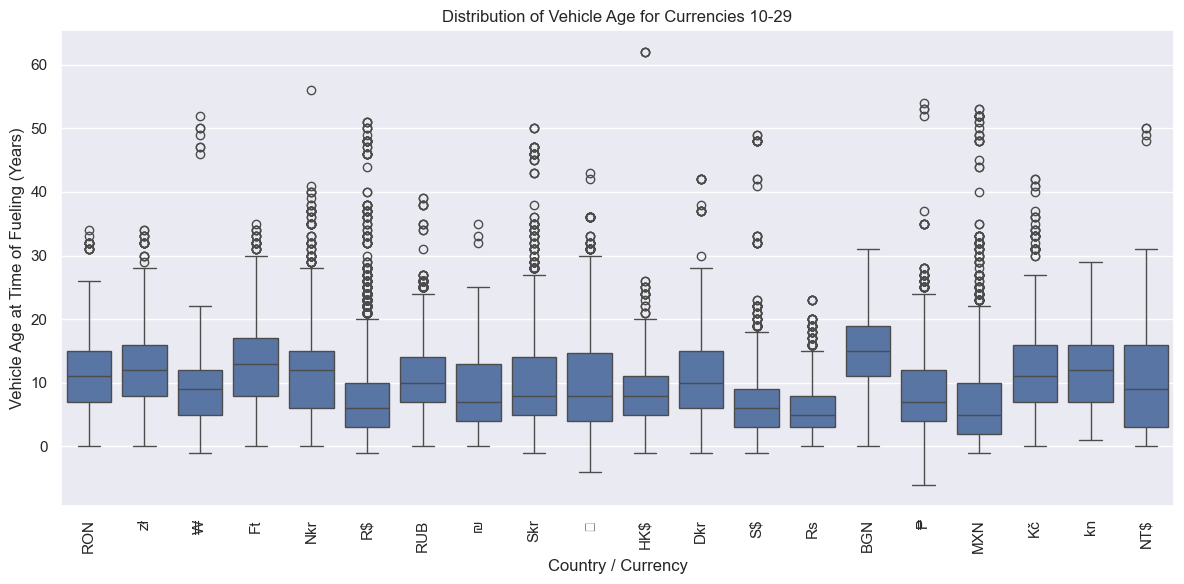

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


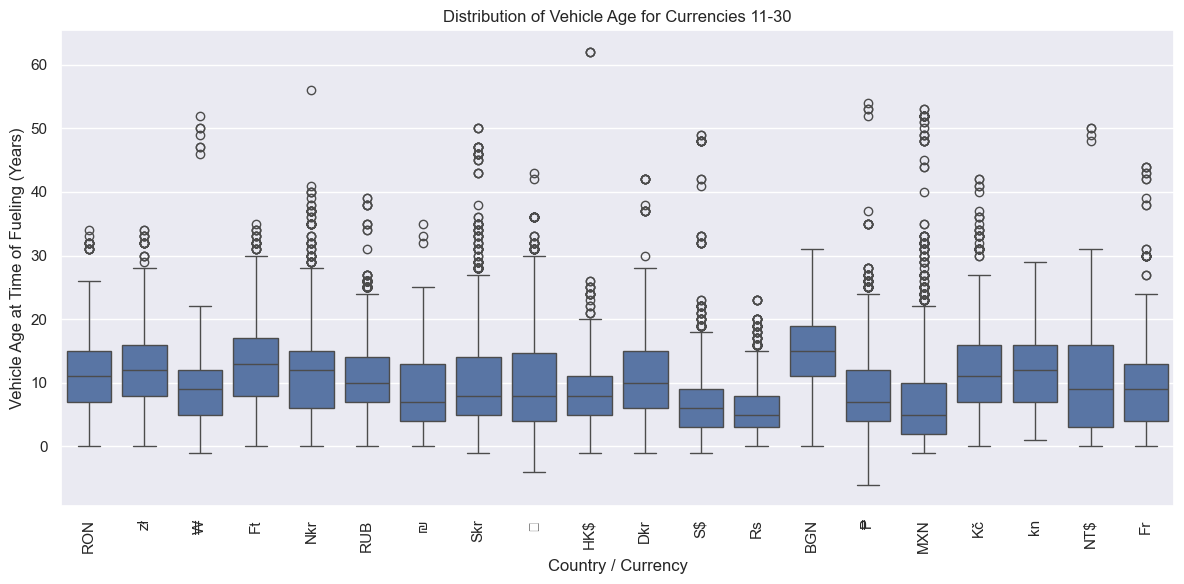

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


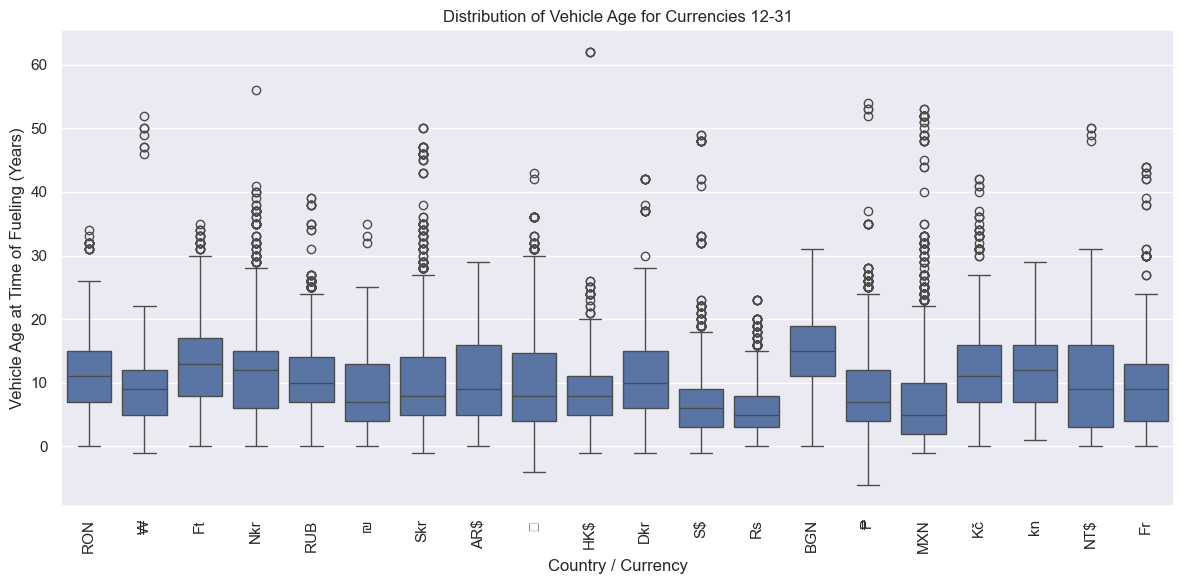

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


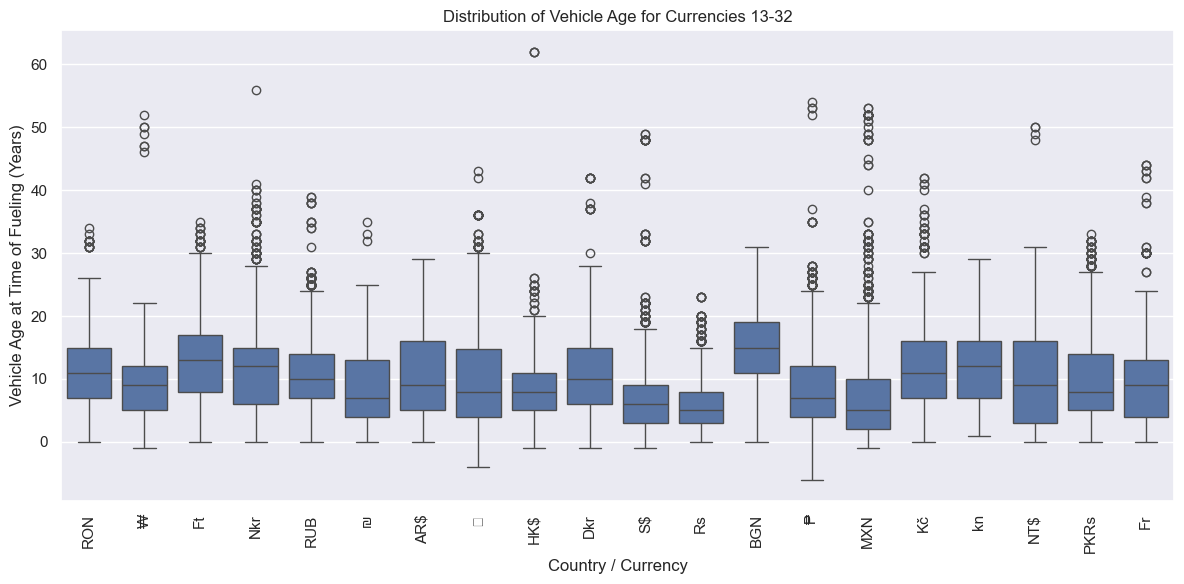

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


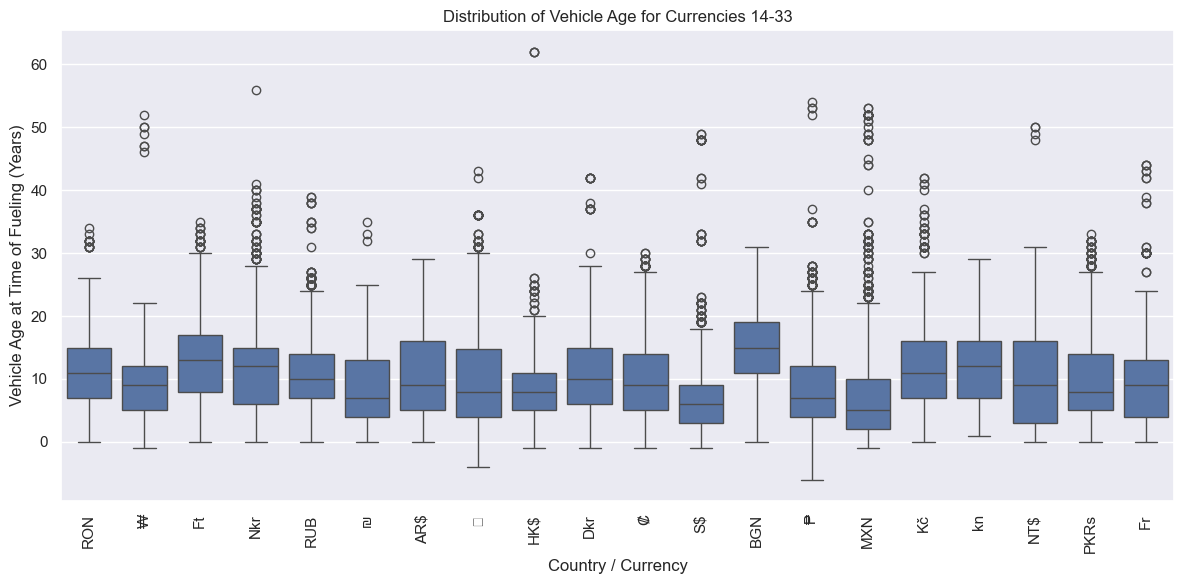

C:\Users\daniel.ngobe\AppData\Local\Temp\ipykernel_28756\4201001170.py:14: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Repo\IDVE_Assignment1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


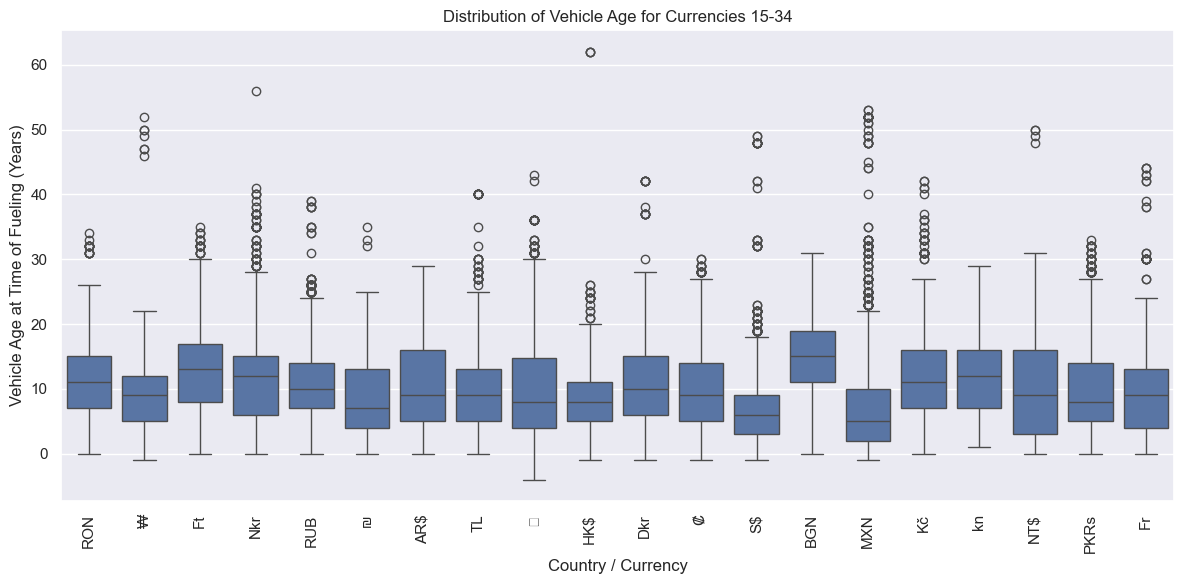

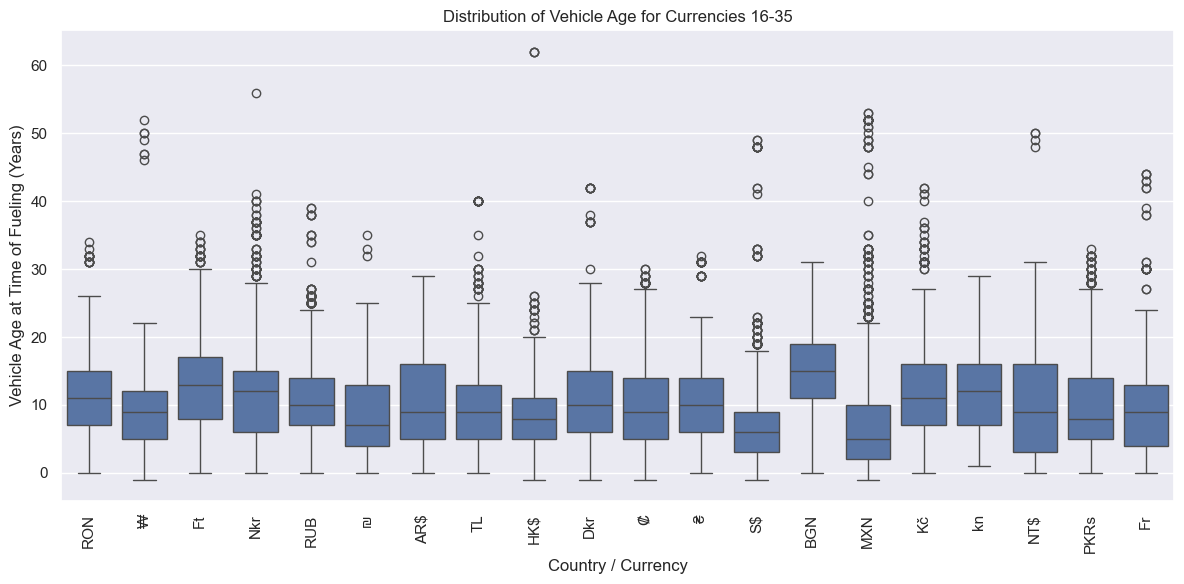

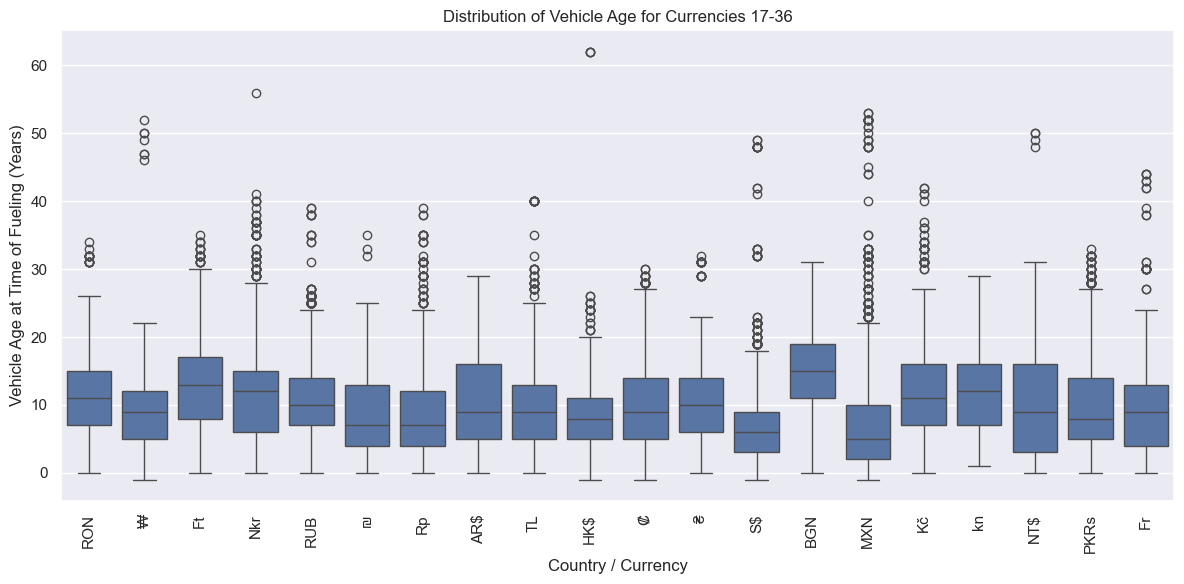

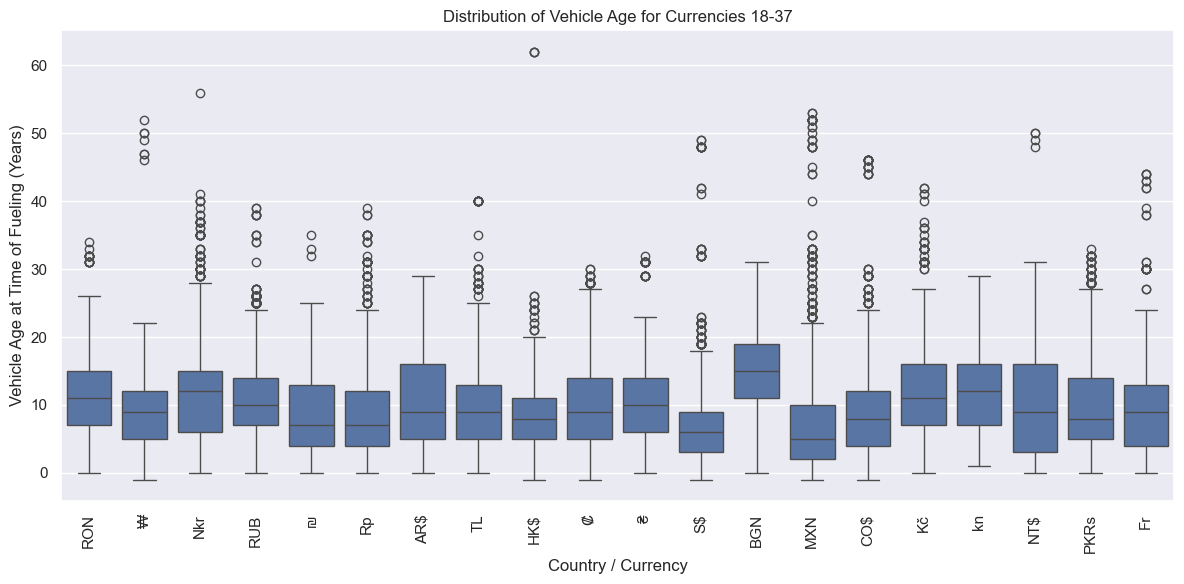

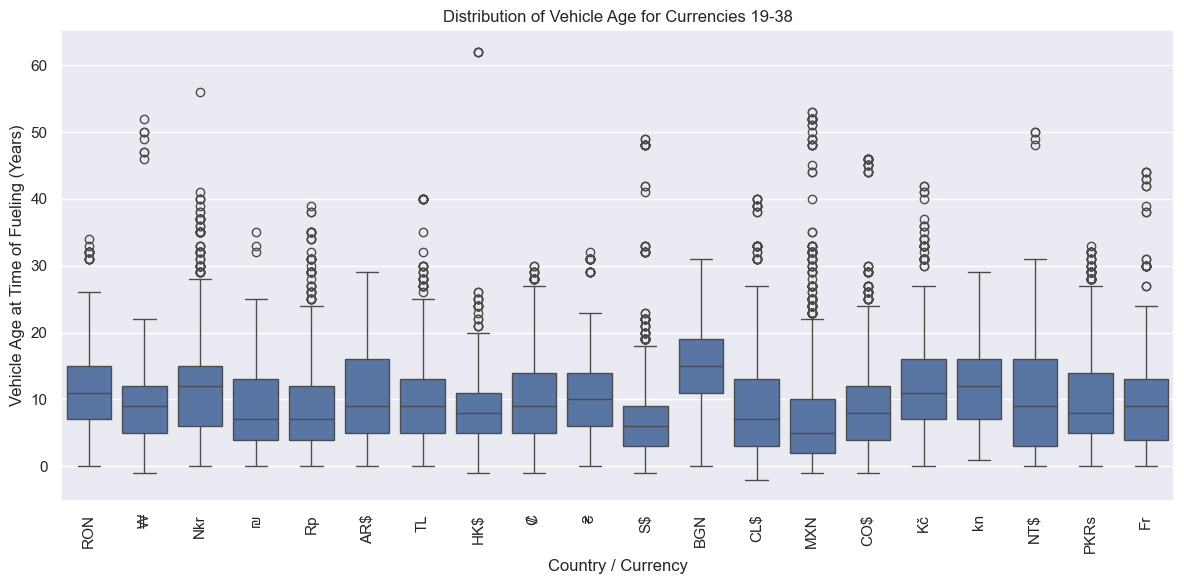

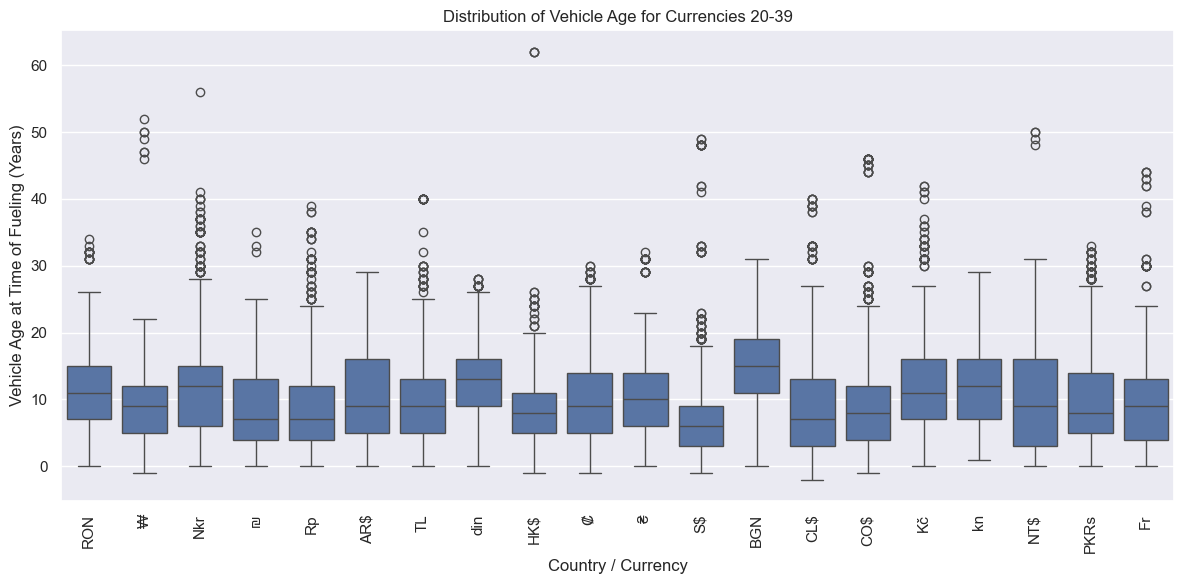

In [79]:
# Get unique currencies sorted by number of entries
df['vehicle_age'] = df['date_fueled_proxy'].dt.year - df['car_year']
currencies_sorted = df['currency'].value_counts().index

chunk_size = 20
for i in range(0, 20):
    chunk = currencies_sorted[i:i+chunk_size]
    plt.figure(figsize=(12,6))
    sns.boxplot(x='currency', y='vehicle_age', data=df[df['currency'].isin(chunk)])
    plt.xticks(rotation=90)
    plt.ylabel('Vehicle Age at Time of Fueling (Years)')
    plt.xlabel('Country / Currency')
    plt.title(f'Distribution of Vehicle Age for Currencies {i+1}-{i+len(chunk)}')
    plt.tight_layout()
    plt.show()

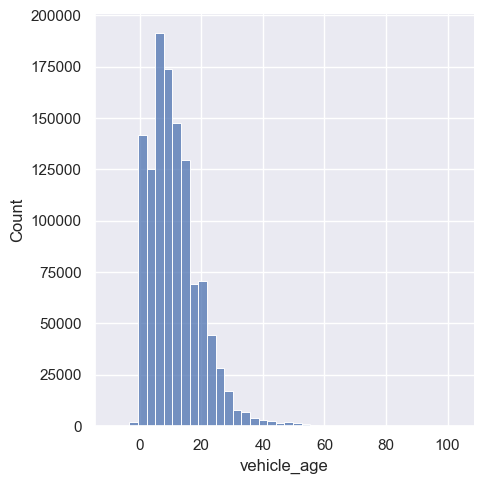

In [80]:
sns.displot(data=df, x= df['vehicle_age'], bins=40)

#### 4. Which makes and models of vehicles are the most popular?

In [81]:
most_popular_vehicle = df.groupby(['car_make', 'car_model']).car_make.count().reset_index(name='count')
most_popular_vehicle.nlargest(n=10, columns=['count'])

,car_make,car_model,count
692,honda,civic,8082
1937,toyota,4runner,7810
1972,toyota,corolla,7737
565,ford,f-150,7661
676,honda,accord,7633
627,ford,mustang,7520
642,ford,ranger,7424
2013,toyota,land_cruiser,7388
1964,toyota,camry,7316
888,jeep,wrangler,7061


In [82]:
df.sample(5)

,user_id,date_fueled_proxy,currency,total_spent_float,cpg_float,car_make,car_model,car_year,km_driven,litres_filled,...,cost_per_gallon,total_spent,date_fueled,date_captured,miles,odometer,gallons,mpg,user_url,vehicle_age
41455,1015329,2021-08-20,$,41.75,2.829,honda,pilot,2020.0,572.429202346,55.868892520056,...,$2.829,$41.75,NaT,2021-08-20,355.69190000000003,8705.0,14.759,24.1,https://www.somewebsite.com/honda/pilot/2020/1...,1.0
1140620,357259,2015-10-22,$,18.6,1.998,toyota,prius,2003.0,708.69379042,35.24218370904,...,$1.998,$18.60,2015-10-22,2016-06-06,440.363,134187.0,9.31,47.3,https://www.somewebsite.com/toyota/prius/2003/...,12.0
998397,622112,2022-02-14,$,21.1,3.259,hyundai,elantra,2009.0,197.95847604,24.506755889616,...,$3.259,$21.10,2022-02-14,2022-02-14,123.006,173039.0,6.474,19.0,https://www.somewebsite.com/hyundai/elantra/20...,13.0
799813,589655,2012-06-28,nan,NaN,NaN,audi,a6,2008.0,NaN,NaN,...,NaN,NaN,2012-06-28,2017-03-14,NaN,18110.0,NaN,NaN,https://www.somewebsite.com/audi/a6/2008/589655,4.0
1034158,804583,2021-08-16,$,39.25,3.699,mini,cooper_countryman,2012.0,455.94806995799996,40.167004440024,...,$3.699,$39.25,2021-08-16,2021-08-16,283.3137,60299.0,10.611,26.7,https://www.somewebsite.com/mini/cooper_countr...,9.0


## 4. Fuel Usage

#### 1. Identify the top 5 currencies by number of transactions.

In [83]:
# consistency reasons - cost per gallon is converted to cost per litre
# divide fuel price (U.S. gallon) by 3.785411784 to get cost per litre
df['cpl_float'] = df['cpg_float']/3.785411784

# top 5 currencies with most entries
# Replace the string 'nan' with real NaN
df['currency'] = df['currency'].replace('nan', np.nan)

# Now count top 5 currencies ignoring NaNs
top_currencies = df['currency'].value_counts(dropna=True).head(5).rename_axis('currency').reset_index(name='count')

df['currency'].value_counts().rename_axis('currency')[:5].reset_index(name='count')

,currency,count
0,$,741953
1,£,87587
2,€,59273
3,CA$,46848
4,R,36424


#### 2. For each of the top 5 currencies separately, remove outliers by considering the total spend, litres, cost per litre, gallons, etc.

In [84]:
top_currencies = ['$', '£', '€', 'CA$', 'R']
top_5_df = df[df['currency'].isin(top_currencies)]

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

numeric_cols = ['total_spent_float', 'litres_filled', 'cpl_float', 'gallons', 'km_driven', 'mpg', 'litres_per_100km']

cleaned_dfs = []

for cur in top_currencies:
    temp_df = top_5_df[top_5_df['currency'] == cur]
    for col in numeric_cols:
        if col in temp_df.columns:
            temp_df = remove_outliers_iqr(temp_df, col)
    cleaned_dfs.append(temp_df)

# Combine back
cleaned_top5_df = pd.concat(cleaned_dfs)

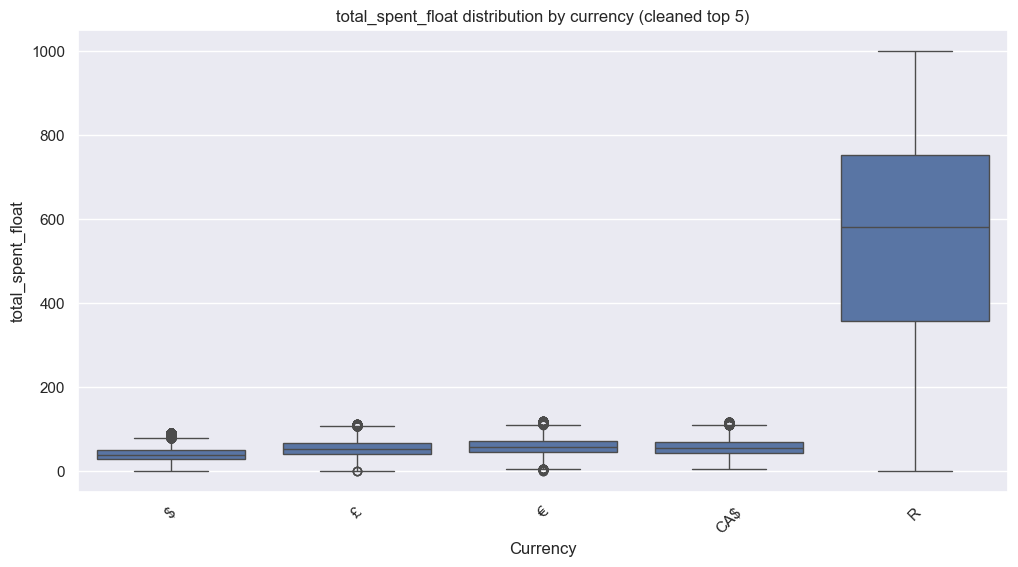

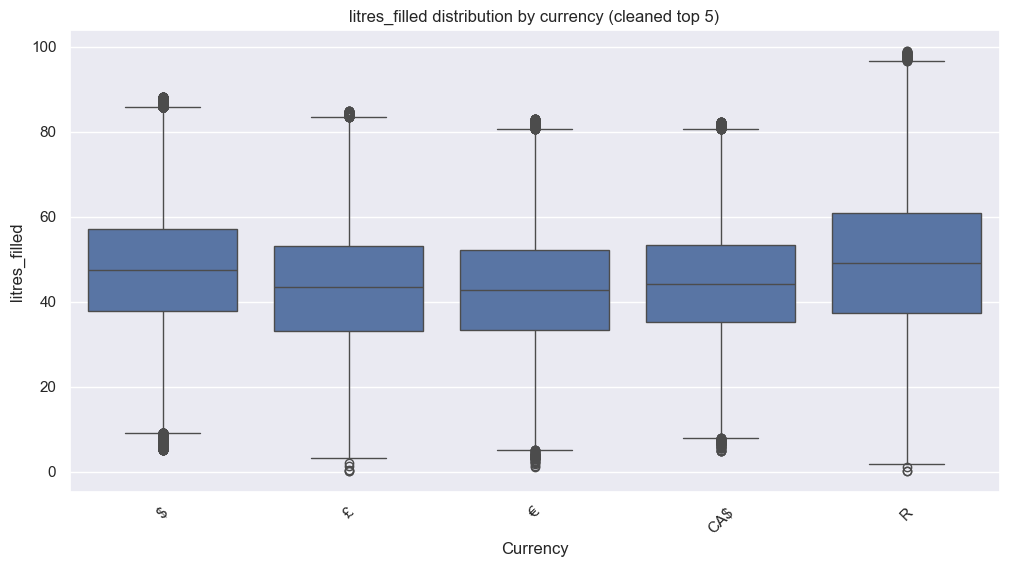

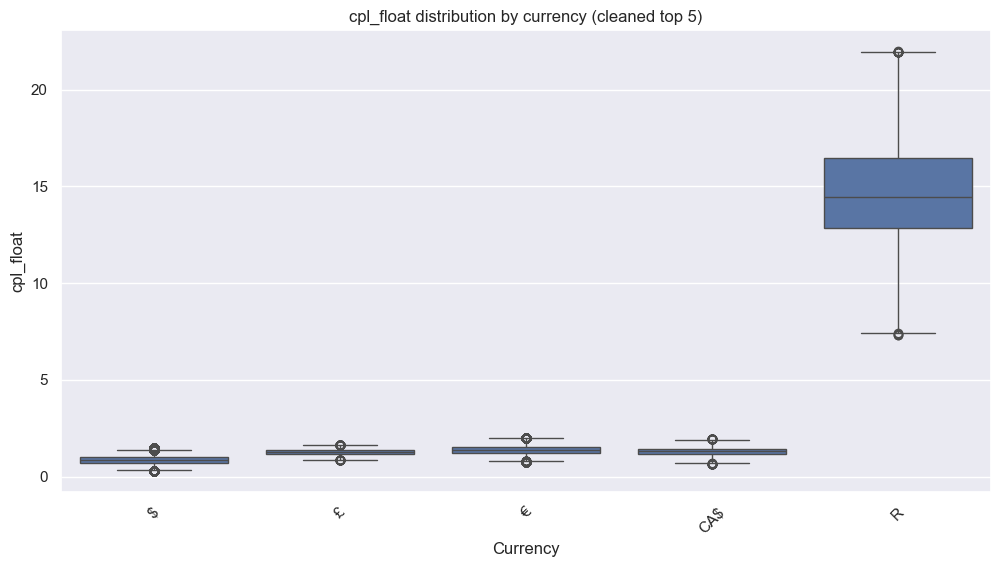

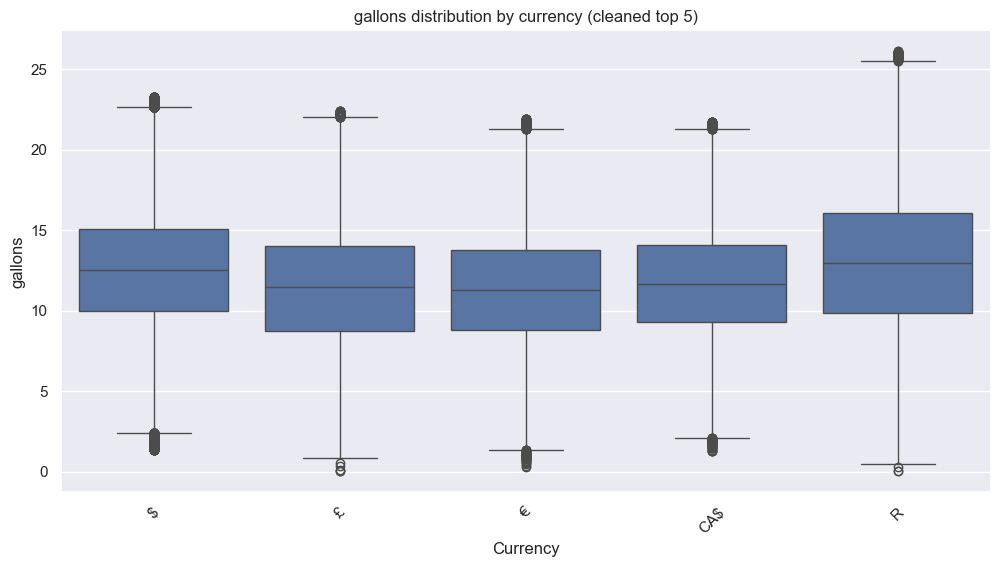

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['total_spent_float', 'litres_filled', 'cpl_float', 'gallons']

for col in numeric_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='currency', y=col, data=cleaned_top5_df)
    plt.xticks(rotation=45)
    plt.title(f'{col} distribution by currency (cleaned top 5)')
    plt.ylabel(col)
    plt.xlabel('Currency')
    plt.show()

In [86]:
# (optional) ⁉️
# for col in numeric_cols:
#     plt.figure(figsize=(12,6))
#     sns.histplot(data=cleaned_top5_df, x=col, hue='currency', element='step', stat='density', common_norm=False)
#     plt.title(f'{col} distribution by currency (cleaned top 5)')
#     plt.xlabel(col)
#     plt.ylabel('Density')
#     plt.show()

<b>Reasoning</b>

IQR method: Removes extreme outliers while keeping most data.

Per currency: Prices and fuel amounts vary by country/currency, so outlier thresholds should be computed separately.

Columns considered:

- total_spent_float: extremely high fuel spends may be errors.
- litres_filled / gallons: unrealistic tank sizes.
- cpl_float: extreme fuel price entries.
- km_driven / mpg / litres_per_100km: extreme efficiency values.

#### 3. How many values have been removed after accounting for outliers?

In [87]:
# Original number of rows for top 5 currencies
original_count = top_5_df.shape[0]

# Number of rows after removing outliers
cleaned_count = cleaned_top5_df.shape[0]

# Number of rows removed
removed_count = original_count - cleaned_count

print(f'Original rows: {original_count}')
print(f'Rows after cleaning: {cleaned_count}')
print(f'Number of rows removed as outliers: {removed_count}')
print(f'Percentage of rows removed: {removed_count/original_count*100:.2f}%')

Original rows: 972085
Rows after cleaning: 702235
Number of rows removed as outliers: 269850
Percentage of rows removed: 27.76%


### 4.2. Fuel Efficiency


#### 1. Look at the difference in cost per litre per country for January 2022 - use the average currency conversion rate to Rands
https://www.nedbank.co.za/content/dam/nedbank/site-assets/AboutUs/Economics_Unit/Forecast_and_data/Daily_Rates/Monthly_Average_Exchange_Rates.pdf


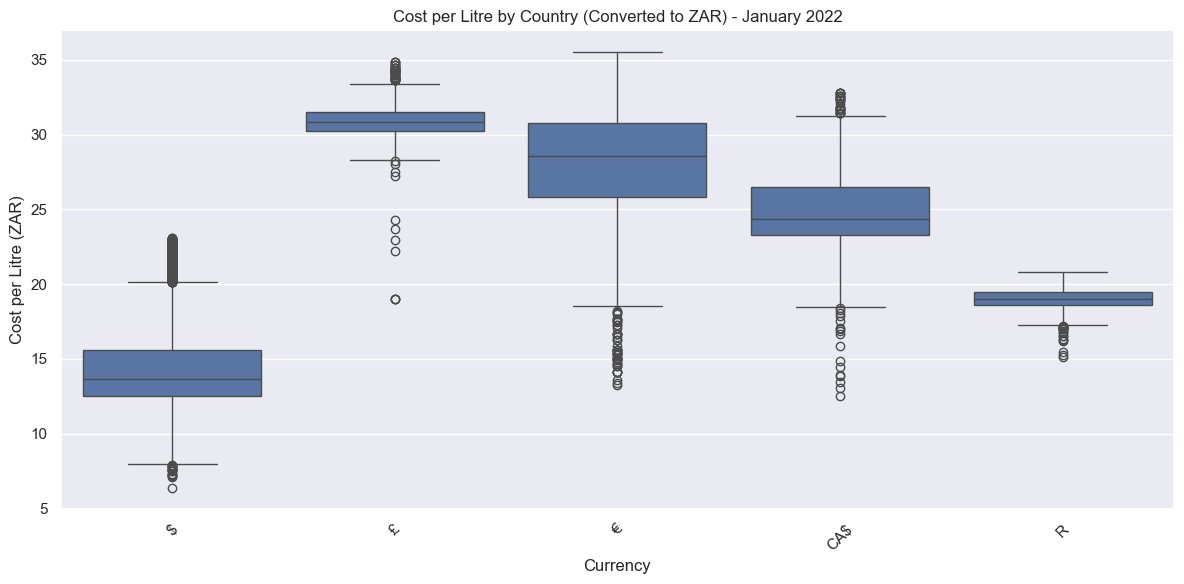

In [88]:
# Define exchange rates for January 2022
exchange_rates = {
    '$': 15.5972,  # USD to ZAR
    '€': 17.6922,  # EUR to ZAR
    '£': 21.1473,  # GBP to ZAR
    'CA$': 17.0088  # CAD to ZAR
}

# Filter for January 2022
jan_2022_df = cleaned_top5_df[
    (cleaned_top5_df['date_fueled_proxy'].dt.year == 2022) &
    (cleaned_top5_df['date_fueled_proxy'].dt.month == 1)
]

# Convert cost per litre to ZAR
jan_2022_df['cpl_zar'] = jan_2022_df.apply(
    lambda row: row['cpl_float'] * exchange_rates.get(row['currency'], 1)
    if row['currency'] in exchange_rates else row['cpl_float'],
    axis=1
)

# Plot the distribution for January 2022
plt.figure(figsize=(12, 6))
sns.boxplot(x='currency', y='cpl_zar', data=jan_2022_df)
plt.title('Cost per Litre by Country (Converted to ZAR) - January 2022')
plt.xlabel('Currency')
plt.ylabel('Cost per Litre (ZAR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




#### 2. Looking at the odometer readings, find examples of where users have missed logging a fill-up. Give a basic rule for identifying this, and estimate how many there are in the dataset.

In [89]:
# Ensure date_fueled_proxy is datetime
cleaned_top5_df = cleaned_top5_df.sort_values(['user_id', 'date_fueled_proxy'])
# Compute difference in km driven between consecutive logs for each user
cleaned_top5_df['km_diff'] = cleaned_top5_df.groupby('user_id')['km_driven'].diff()
# km_diff is NaN for the first fill-up per user.
# Large values of km_diff may indicate missed fill-ups.

# Example: flag km_diff greater than 2 times the user's median distance per fill-up
cleaned_top5_df['median_km'] = cleaned_top5_df.groupby('user_id')['km_driven'].transform('median')
cleaned_top5_df['missed_fillup'] = cleaned_top5_df['km_diff'] > 2 * cleaned_top5_df['median_km']

# Show examples
missed_examples = cleaned_top5_df[cleaned_top5_df['missed_fillup']][['user_id', 'date_fueled_proxy', 'odometer', 'km_diff']]
print(missed_examples.head(10))


        user_id date_fueled_proxy  odometer            km_diff
248020  1013634        2020-10-01  174288.0 484.89542947200005
651046   101552        2012-04-16       NaN           635.6893
390378  1019106        2021-12-29   17099.0  464.8795850900001
965753  1021272        2020-01-19   77378.0       654.57651424
791260   102979        2013-03-19       NaN         534.783682
952178  1043078        2021-09-26   92481.0      600.437672904
823523  1055904        2022-02-13  101370.0  399.1689454180001
522853  1071108        2022-04-03   70531.0      638.907658132
147672  1073763        2021-10-24  173213.0  727.8196697819999
298024  1078997        2021-07-13   21122.0       585.72573036


Basic Rule

- Sort by user and fueling date.
- Compute km_diff between consecutive refuels.
- If km_diff > 1.5 × median km per fill-up for that user, flag as potential missed fill-up.
- Threshold can be adjusted based on typical driving patterns.
- This is a simple, heuristic approach; more advanced methods can consider MPG, fuel tank size, or expected distances.

#### 3. Plot the average distance (in km) per tank per country. Which country has the largest average distance? Provide some explanations for why this might be the case.

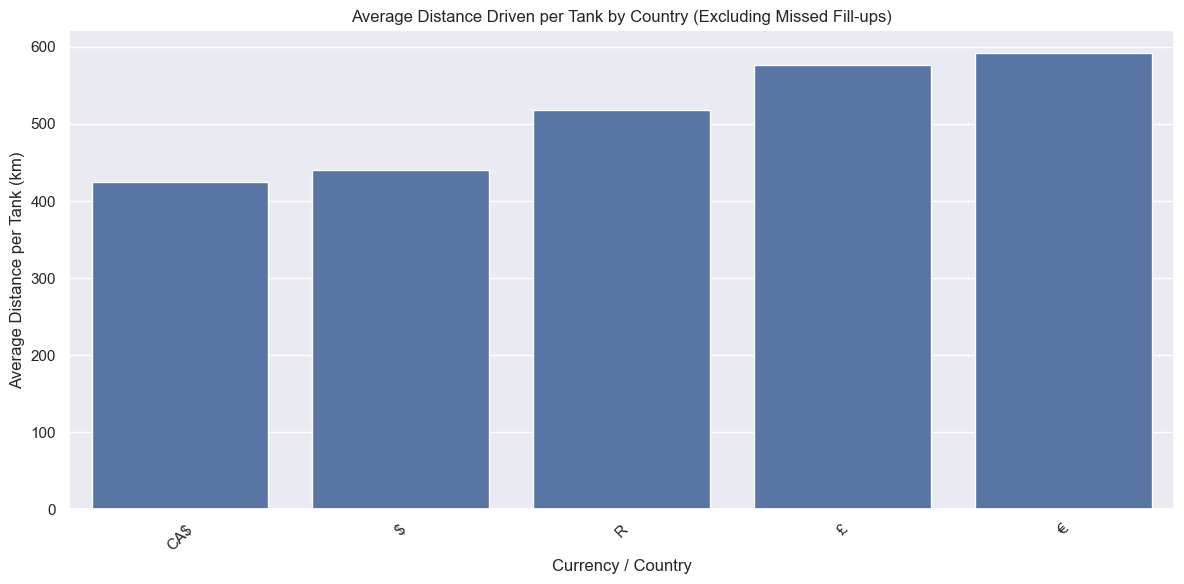

Country with largest average distance: € (591.8 km per tank)


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows flagged as missed fill-ups
valid_fillups = cleaned_top5_df[~cleaned_top5_df['missed_fillup']]

# Group by currency and calculate mean km per tank
avg_distance_per_currency = valid_fillups.groupby('currency')['km_driven'].mean().sort_values()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=avg_distance_per_currency.index, y=avg_distance_per_currency.values)
plt.xlabel('Currency / Country')
plt.ylabel('Average Distance per Tank (km)')
plt.title('Average Distance Driven per Tank by Country (Excluding Missed Fill-ups)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify country with largest average distance
max_currency = avg_distance_per_currency.idxmax()
max_distance = avg_distance_per_currency.max()
print(f'Country with largest average distance: {max_currency} ({max_distance:.1f} km per tank)')


€. has the largest average distance. The reason for this might be that cars in other countries are simply not as fuel-efficient as those in

€.. These cars are designed to accommodate

€. gas prices, which are probably far higher than other countries gas prices. As a result, €. vehicles allow drivers to achieve greater miles per gallon (km per litre).

#### 4. Do newer vehicles drive further distances between fill-ups? Provide a plot to show this. 

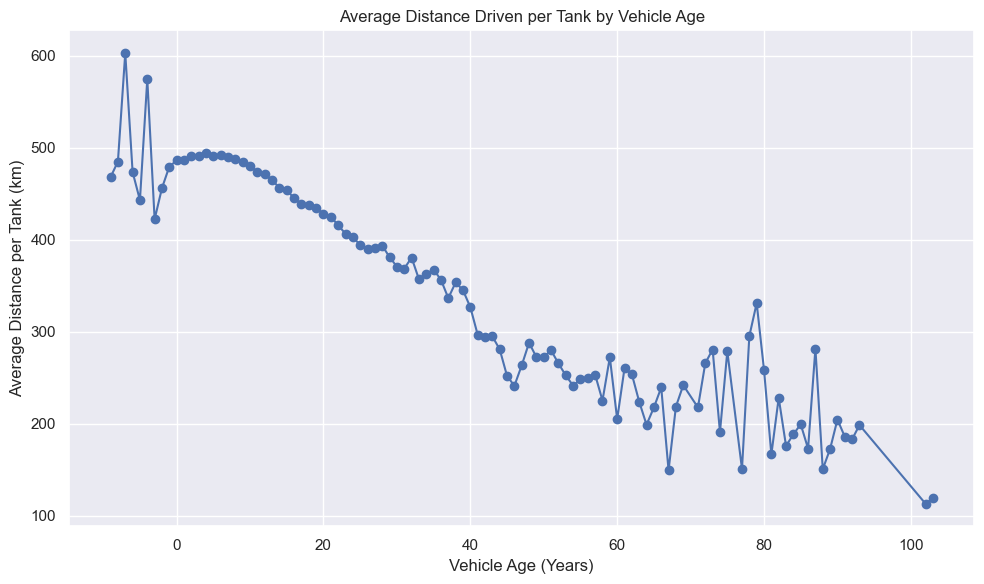

In [91]:
valid_fillups = cleaned_top5_df[~cleaned_top5_df['missed_fillup']]
avg_distance_per_age = valid_fillups.groupby('vehicle_age')['km_driven'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_distance_per_age.index, avg_distance_per_age.values, marker='o')
plt.title('Average Distance Driven per Tank by Vehicle Age')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Average Distance per Tank (km)')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5. Take the top 5 most popular vehicles in SA (ie, those with currency set to R). Compute their fuel efficiency and discuss whether these values are realistic.

Top 5 vehicles in SA: Index(['toyota hilux', 'mitsubishi pajero', 'toyota fortuner', 'suzuki jimny',
       'volkswagen amarok'],
      dtype='object', name='vehicle')

 
  vehicle
mitsubishi pajero   12.795485278413853
toyota hilux        11.876424822678562
toyota fortuner      11.30165747088646
volkswagen amarok    10.72328094179989
suzuki jimny         9.169601536180766
Name: litres_per_100km, dtype: float64


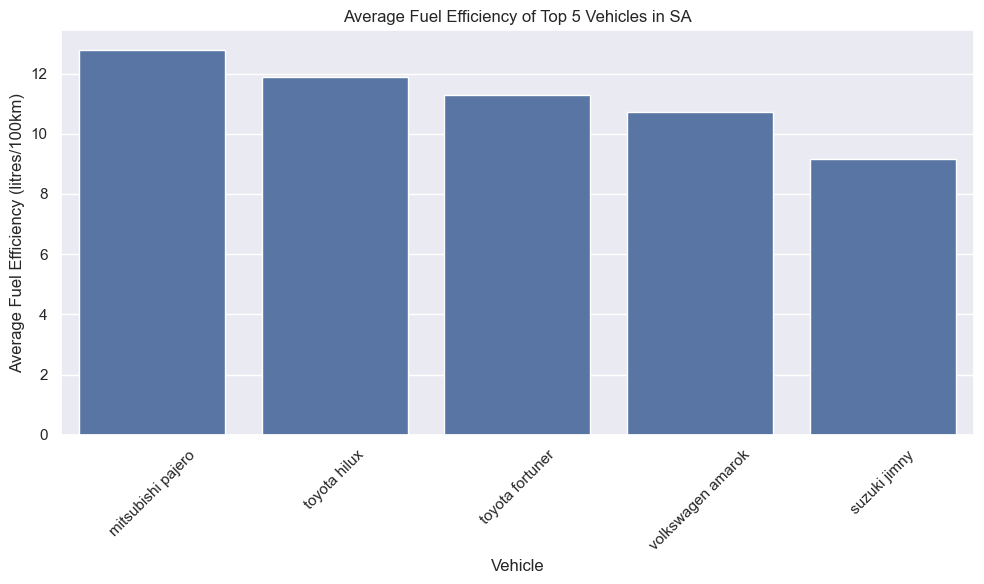

In [92]:
# Filter for South Africa
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R']

# Count most popular vehicles
sa_df['vehicle'] = sa_df['car_make'] + ' ' + sa_df['car_model']
top5_vehicles = sa_df['vehicle'].value_counts().head(5).index
print("Top 5 vehicles in SA:", top5_vehicles)


# # Calculate km per litre
sa_df['km_per_litre'] = sa_df['km_driven'] / sa_df['litres_filled']

# Filter only top 5 vehicles
top5_sa_df = sa_df[sa_df['vehicle'].isin(top5_vehicles)]

# Compute average fuel efficiency per vehicle
fuel_efficiency = top5_sa_df.groupby('vehicle')['litres_per_100km'].mean().sort_values(ascending=False)
print("\n \n ",fuel_efficiency)

plt.figure(figsize=(10,6))
sns.barplot(x=fuel_efficiency.index, y=fuel_efficiency.values)
plt.ylabel('Average Fuel Efficiency (litres/100km)')
plt.xlabel('Vehicle')
plt.title('Average Fuel Efficiency of Top 5 Vehicles in SA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 6. Which vehicles are the most fuel efficient in each country?

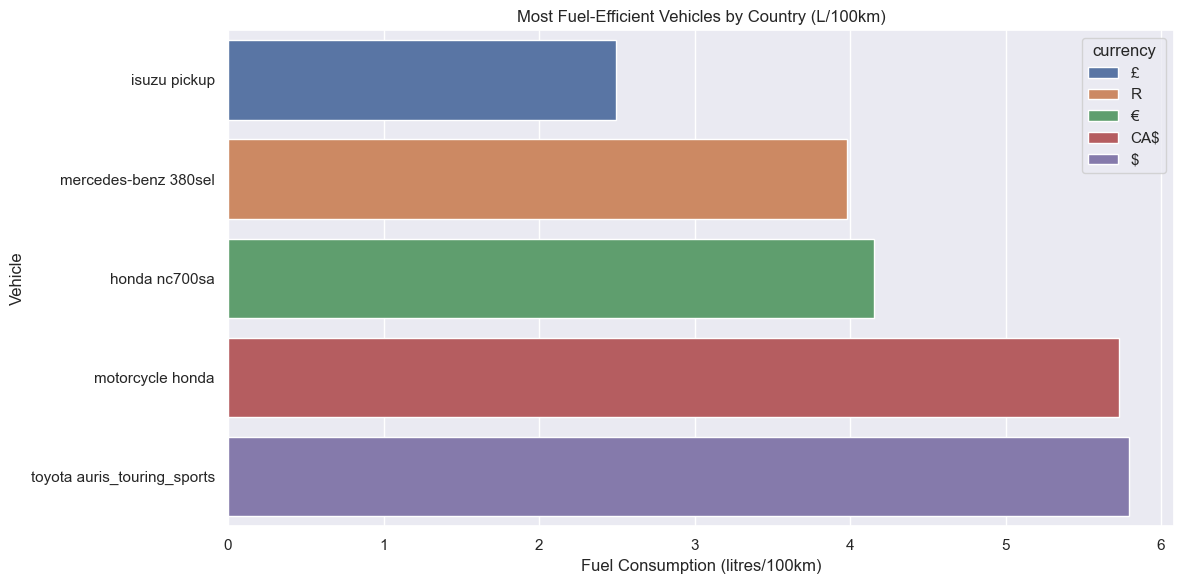

In [93]:
# Identify most fuel-efficient vehicles per country using litres per 100 km
vehicle_efficiency = cleaned_top5_df.groupby(
    ['car_make', 'car_model', 'currency']
)['litres_per_100km'].mean().reset_index()

# Pick the vehicle with lowest litres per 100km per country
most_efficient_vehicles = vehicle_efficiency.loc[
    vehicle_efficiency.groupby('currency')['litres_per_100km'].idxmin()
]

# Combine make and model for readability
most_efficient_vehicles['vehicle'] = most_efficient_vehicles['car_make'] + ' ' + most_efficient_vehicles['car_model']

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    x='litres_per_100km', 
    y='vehicle', 
    data=most_efficient_vehicles.sort_values('litres_per_100km'),
    hue='currency',
    dodge=False
)
plt.title('Most Fuel-Efficient Vehicles by Country (L/100km)')
plt.xlabel('Fuel Consumption (litres/100km)')
plt.ylabel('Vehicle')
plt.tight_layout()
plt.show()


In [94]:
print("Most Fuel Efficient Vehicles in R:")
most_efficient_vehicles[most_efficient_vehicles['currency'].isin(['R'])].nsmallest(5, 'litres_per_100km')

Most Fuel Efficient Vehicles in R:


,car_make,car_model,currency,litres_per_100km,vehicle
2344,mercedes-benz,380sel,R,3.977258918375421,mercedes-benz 380sel


To ensure the values are reasonable, we can compare the calculated fuel efficiencies with known benchmarks for typical fuel consumption:
- Suzuki Celerio 1.0 GL: 4.2 L/100km
- Toyota Vitz 1.0 XR: 4.2 L/100km
- Renault Kwid: 4.4 L/100km
- Suzuki Swift 1.2: 4.4 L/100km
- Suzuki S-Presso 1.0: 4.6 L/100km
- Volkswagen Polo Vivo GT 1.0 TSI: 4.8 L/100km
- Honda Jazz: 5.6 L/100km
- Volkswagen Polo: 5.7 L/100km
* These figures are based on manufacturer claims and real-world data .

#### 7. Plot the difference in fuel efficiency for the top 5 Canadian vehicles between seasons. Would you expect to see big differences, and do you see them?

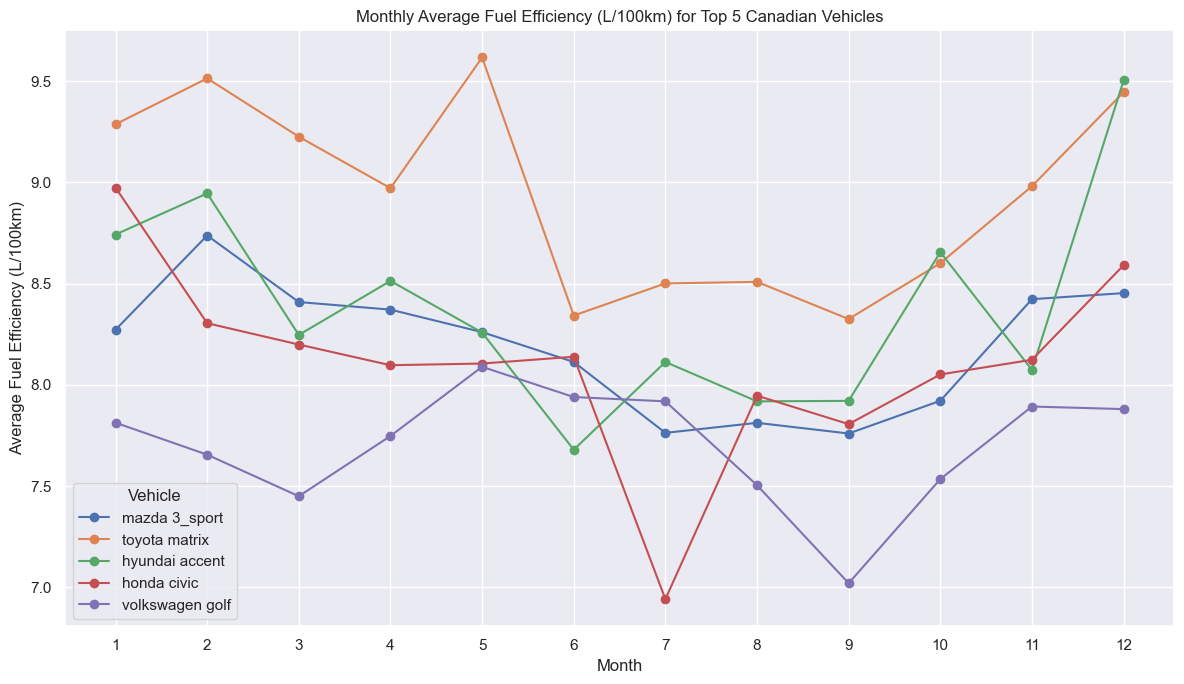

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Canadian vehicles
ca_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'CA$'].copy()

# Get top 5 most popular Canadian vehicles
ca_df['vehicle'] = ca_df['car_make'] + ' ' + ca_df['car_model']
top5_ca_vehicles = ca_df['vehicle'].value_counts().head(5).index

# Filter only top 5 vehicles
ca_top5 = ca_df[ca_df['vehicle'].isin(top5_ca_vehicles)]

# Group by vehicle and month, then calculate mean fuel efficiency
monthly_eff = ca_top5.groupby([ca_top5['date_fueled_proxy'].dt.month, 'vehicle'])['litres_per_100km'].mean().reset_index()

plt.figure(figsize=(12, 7))
for vehicle in top5_ca_vehicles:
    data = monthly_eff[monthly_eff['vehicle'] == vehicle]
    plt.plot(data['date_fueled_proxy'], data['litres_per_100km'], marker='o', label=vehicle)

plt.title('Monthly Average Fuel Efficiency (L/100km) for Top 5 Canadian Vehicles')
plt.ylabel('Average Fuel Efficiency (L/100km)')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.legend(title='Vehicle')
plt.tight_layout()
plt.show()


#### 8. Show the correlations between fuel efficiency and other features. You should find that there is a relative strongly correlation with distance travelled, the age of the vehicle, and the model of vehicle. 